In [6]:
import pandas as pd
import plotly.express as px

from btdcore.utils import batched

In [158]:
# https://www.kaggle.com/datasets/jithinanievarghese/cosmetics-and-beauty-products-reviews-top-brands
df = pd.read_csv("./nyka_top_brands_cosmetics_product_reviews.csv")

Rough estimate of how many are about shampoo:

In [8]:
df.iloc[0]

product_id                                                         781070
brand_name                                                           Olay
review_id                                                        16752142
review_title                                         Worth buying 50g one
review_text             Works as it claims. Could see the difference f...
author                                                      Ashton Dsouza
review_date                                           2021-01-23 15:17:18
review_rating                                                         5.0
is_a_buyer                                                           True
pro_user                                                            False
review_label                                               Verified Buyer
product_title           Olay Ultra Lightweight Moisturiser: Luminous W...
mrp                                                                  1999
price                                 

In [9]:
df["product_id"].value_counts().describe()

count    295.000000
mean     207.742373
std      288.959583
min        1.000000
25%        3.000000
50%       17.000000
75%      346.500000
max      800.000000
Name: count, dtype: float64

In [10]:
len(df[df["product_title"].str.lower().str.contains("shampoo")])

4447

In [11]:
from expert_llm import OpenAIApiClient
from expert_llm.api import LlmApi
from common import RequestPersisterLogfile

In [22]:
llm = LlmApi(OpenAIApiClient(
    "gpt-4.1-nano",
    request_persister=RequestPersisterLogfile(),
))
embedder = OpenAIApiClient(
    "text-embedding-3-small",
    request_persister=RequestPersisterLogfile(),
)

# Group products
- embeddings similarity

In [23]:
BATCH_SIZE = 100
product_names = list(df["product_title"].unique())
len(product_names)

292

In [24]:
product_name_embeddings: list[list[float]] = []

In [25]:
for batch in batched(product_names, BATCH_SIZE):
    batch_embeddings = embedder.embed(batch)
    product_name_embeddings.extend(batch_embeddings)
    pass

In [26]:
from sklearn.cluster import DBSCAN

eps = 0.83
alg = DBSCAN(eps=eps, min_samples=1).fit(product_name_embeddings)

In [27]:
alg.labels_

array([ 0,  1,  2,  3,  4,  5,  4,  4,  4,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  6,
        6,  6,  6,  6,  8,  6,  6,  8,  6,  6,  8,  9,  6,  9,  6,  6, 10,
       10, 11, 11, 11,  6,  6, 12,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6, 13,  6, 12,  6,  6,  6,  6, 12,  6,  6,
        8,  8,  8,  9,  6,  6,  6,  6,  6, 14,  6, 12,  6,  6,  6,  6,  6,
        6,  6,  6,  8,  8,  8,  8,  8,  8,  8,  8,  9,  6,  6,  9,  6,  6,
       15,  6,  6,  6,  6, 16, 17, 18, 11, 11, 11, 11, 11, 11, 19, 11, 18,
       11, 11, 20, 11, 11, 11, 11, 21, 11, 11, 11, 11, 11, 22, 11, 23, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 24,
       11, 25, 26, 11, 11, 11, 27, 28, 11, 29, 11, 11, 25, 11, 11, 27, 11,
       11, 30, 27, 27, 11

In [83]:
product_name_groups = {
    group_id: []
    for group_id in set(alg.labels_)
}
for product_name_idx, group_id in enumerate(alg.labels_):
    product_name_groups[group_id].append(product_names[product_name_idx])
    pass

Think we'll focus on group 35, the shampoos

In [71]:
clause = [False * len(df)]
for product_name in product_name_groups[35]:
    clause = clause | (df["product_title"] == product_name)
    pass
rel = df[clause].reset_index(drop=True)
rel.describe()

/var/folders/_v/gwj34jjx21lcg89_06hppbbm0000gn/T/ipykernel_17319/1019693389.py:3: FutureWarning:

Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.



,product_id,review_id,review_rating,mrp,price,product_rating,product_rating_count
count,6.197000e+03,6.197000e+03,6197.000000,6197.000000,6197.000000,6197.000000,6197.000000
mean,2.763419e+06,1.482902e+07,4.329030,744.396482,480.536389,4.293965,3484.740842
std,2.312672e+06,5.819532e+06,1.178138,279.981379,181.512657,0.101087,3192.297346
min,4.524420e+05,4.625565e+06,1.000000,380.000000,277.000000,4.100000,65.000000
25%,4.524490e+05,1.111606e+07,4.000000,600.000000,390.000000,4.200000,1093.000000
50%,1.135935e+06,1.497161e+07,5.000000,650.000000,390.000000,4.300000,2077.000000
75%,5.360838e+06,1.848501e+07,5.000000,750.000000,525.000000,4.400000,5130.000000
max,6.604347e+06,2.962922e+07,5.000000,1850.000000,1295.000000,4.700000,11761.000000


In [30]:
from pydantic import BaseModel

class NeedMention(BaseModel):
    review_id: int
    need_description: str
    was_fulfilled: bool
    pass

In [31]:
def extract_needs(df, idx: int) -> list[NeedMention]:
    row = df.iloc[idx]
    review_context = "\n".join([
        f"Product Name: {row['product_title']}",
        f"Review Title: {row['review_title']}",
        f"Review Body:\n {row['review_text']}",
    ])
    output_schema = {
        "type": "object",
        "properties": {
            "needs": {
                "type": "array",
                "description": "All identified shampoo or conditioner related needs in the reivew",
                "items": {
                    "type": "object",
                    "properties": {
                        "need_description": {
                            "description": "A description of the need",
                            "type": "string",
                        },
                        "was_fulfilled": {
                            "description": "Whether or not the need was fulfilled",
                            "type": "boolean",
                        },
                    },
                },
            },
        },
    }
    response = llm.completion(
        output_schema=output_schema,
        req_name="extract-need-mention",
        system="\n".join([
            "ROLE:",
            "You are an expert beauty care review analyst.",
            "GOAL:",
            "Identify all significant shampoo or conditioner related needs expressed in the following review of a shampoo/conditioner:",
            review_context,
        ]),
        user="Identify the shampoo or conditioner related needs",
    )
    assert response.structured_output
    return [NeedMention(
        review_id=row["review_id"],
        need_description=item["need_description"],
        was_fulfilled=item["was_fulfilled"],
    ) for item in response.structured_output["needs"]]

In [32]:
r = extract_needs(rel, 0)

2025-06-25T08:32:38-0700.629 INFO api - do_req: extract-need-mention


In [33]:
r

[NeedMention(review_id=28585692, need_description='A conditioner that works well and provides smoothness and shine', was_fulfilled=True),
 NeedMention(review_id=28585692, need_description='A conditioner that can be used as a smoothing treatment, possibly once a week', was_fulfilled=True),
 NeedMention(review_id=28585692, need_description='A shampoo that complements the conditioner for optimal results', was_fulfilled=True)]

I love it

In [34]:
import json
import os
from pathlib import Path

CACHE_DIR = Path("./cache")
(CACHE_DIR / "needs").mkdir(exist_ok=True)
(CACHE_DIR / "embeddings").mkdir(exist_ok=True)

In [35]:
def cached_extract_needs(df, idx: int):
    row = df.iloc[idx]
    cache_path = CACHE_DIR / "needs" / f"{row['review_id']}.json"
    if not cache_path.exists():
        needs = extract_needs(df, idx)
        with open(cache_path, "w") as f:
            f.write(json.dumps({
                "needs": [r.model_dump() for r in needs]
            }))
            pass
        return needs
        pass
    with open(cache_path, "r") as f:
        return [
            NeedMention.model_validate(r)
            for r in json.loads(f.read())["needs"]
        ]
    pass

In [36]:
cached_extract_needs(rel, 1)

[NeedMention(review_id=28115711, need_description='Moisturizing or hydrating formula to prevent dryness and improve hair softness', was_fulfilled=False),
 NeedMention(review_id=28115711, need_description='Suitable for dry hair to restore shine and manageability', was_fulfilled=False),
 NeedMention(review_id=28115711, need_description='Gentle cleansing that does not strip natural oils from dry hair', was_fulfilled=False)]

In [37]:
# for i in range(len(rel)):
#     cached_extract_needs(rel, i)
#     pass
None

In [38]:
sample = [
    need
    for i in range(0, 100)
    for need in cached_extract_needs(rel, i)
]

In [39]:
len(sample)

295

In [40]:
from hashlib import md5
import numpy as np

BATCH_SIZE = 100

def cached_embed(texts: list[str]) -> list[list[float]]:
    cache_keys = [
        CACHE_DIR / "embeddings" / md5(text.encode("utf-8")).hexdigest()
        for text in texts
    ]
    cached = [
        np.load(f"{p}.npy", mmap_mode="r").tolist() if p.exists() else None
        for p in cache_keys
    ]
    indexes_need_embeddings = [
        i for i, r in enumerate(cached) if not r
    ]
    for index_batch in batched(indexes_need_embeddings, BATCH_SIZE):
        batch_texts = [texts[i] for i in index_batch]
        batch_embeddings = embedder.embed(batch_texts)
        for embedding_index, text_index in enumerate(index_batch):
            np.save(cache_keys[text_index], batch_embeddings[embedding_index])
            cached[text_index] = batch_embeddings[embedding_index]
            pass
        pass
    return cached

In [41]:
sample_embeddings = cached_embed([s.need_description for s in sample])

In [42]:
def cluster_dbscan(
        *,
        eps: float,
        items: list,
        vectors: list[list[float]],
) -> list[list]:
    alg = DBSCAN(eps=eps, min_samples=1).fit(vectors)
    group_ids = list(set(alg.labels_))
    groups = {
        group_id: []
        for group_id in set(alg.labels_)
    }
    for item_idx, group_id in enumerate(alg.labels_):
        groups[group_id].append(items[item_idx])
        pass
    return list(groups.values())

In [322]:
eps = 0.5

sample_size = 6000
sample = [
    need
    for i in range(0, sample_size)
    for need in cached_extract_needs(rel, i)
]
sample_embeddings = cached_embed([s.need_description for s in sample])
clusters = cluster_dbscan(
    eps=eps,
    items=sample,
    vectors=sample_embeddings,
)

# sort by size, desc
clusters = list(reversed(sorted(clusters, key=lambda x: len(x))))
len(clusters[0])

2025-06-30T07:16:56-0700.737 INFO _tmpfile - clean: TemporaryDirectory.cleanup() worked.


2025-06-30T07:16:56-0700.738 INFO _tmpfile - clean: shutil.rmtree worked.


5563

That looks pretty good

In [77]:
[len(cluster) for cluster in clusters][:20]

[5556,
 560,
 494,
 467,
 407,
 347,
 188,
 60,
 60,
 56,
 48,
 47,
 43,
 37,
 37,
 36,
 36,
 32,
 31,
 29]

I think this is going to generalize well to all the reviews

Let's build a visualization that addresses our primary questions about the dataset:

In [308]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def bubble_plot(
        *,
        need_clusters: list[list[NeedMention]],
        colors: list[str],
        fname: str,
        title: str = "",
):
    assert len(need_clusters) <= len(colors)
    num_mentions: list[int] = []
    percentage_unfulfilleds: list[float] = []
    num_unfulfilleds: list[int] = []
    for cluster in need_clusters:
        num_unfulfilled = len([need for need in cluster if not need.was_fulfilled])
        num_mentions.append(len(cluster))
        percentage_unfulfilleds.append(num_unfulfilled * 100.0 / len(cluster))
        num_unfulfilleds.append(num_unfulfilled)
        pass

    x, y, z = num_mentions, percentage_unfulfilleds, num_unfulfilleds
    fig, ax = plt.subplots(figsize=(8,6), dpi=200)
    z_base = 1
    df = pd.DataFrame({
        "Total Mentions": num_mentions,
        "Percentage Unmet": percentage_unfulfilleds,
    })
    df.index = [
        cluster[0].need_description
        for cluster in need_clusters
    ]

    for i, cluster in enumerate(need_clusters):
        label = cluster[0].need_description
        ax.scatter(
            x=x[i],
            y=y[i],
            s=z[i] + z_base,
            c=colors[i],
            alpha=0.8,
            label=label,
        )
        # plt.text(x[i]+0.05, y[i]+0.05, label)
        pass

    # ax.legend(
    #     bbox_to_anchor=(1.05, 1),
    #     loc='lower left',
    #     borderaxespad=0.,
    # )
    plt.legend(
        loc='lower center',
        bbox_to_anchor=(0.5, -0.55),
        ncol=1
    )
    ax.set_xlabel("Number of mentions")
    ax.set_ylabel("Percentage unmet")
    if title:
        plt.title(title, fontsize=20, pad=10)
        pass
    plt.savefig(fname, bbox_inches="tight")
    plt.show()
    return df

In [81]:
sample_clusters = clusters

/var/folders/_v/gwj34jjx21lcg89_06hppbbm0000gn/T/ipykernel_17319/1855779022.py:35: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.



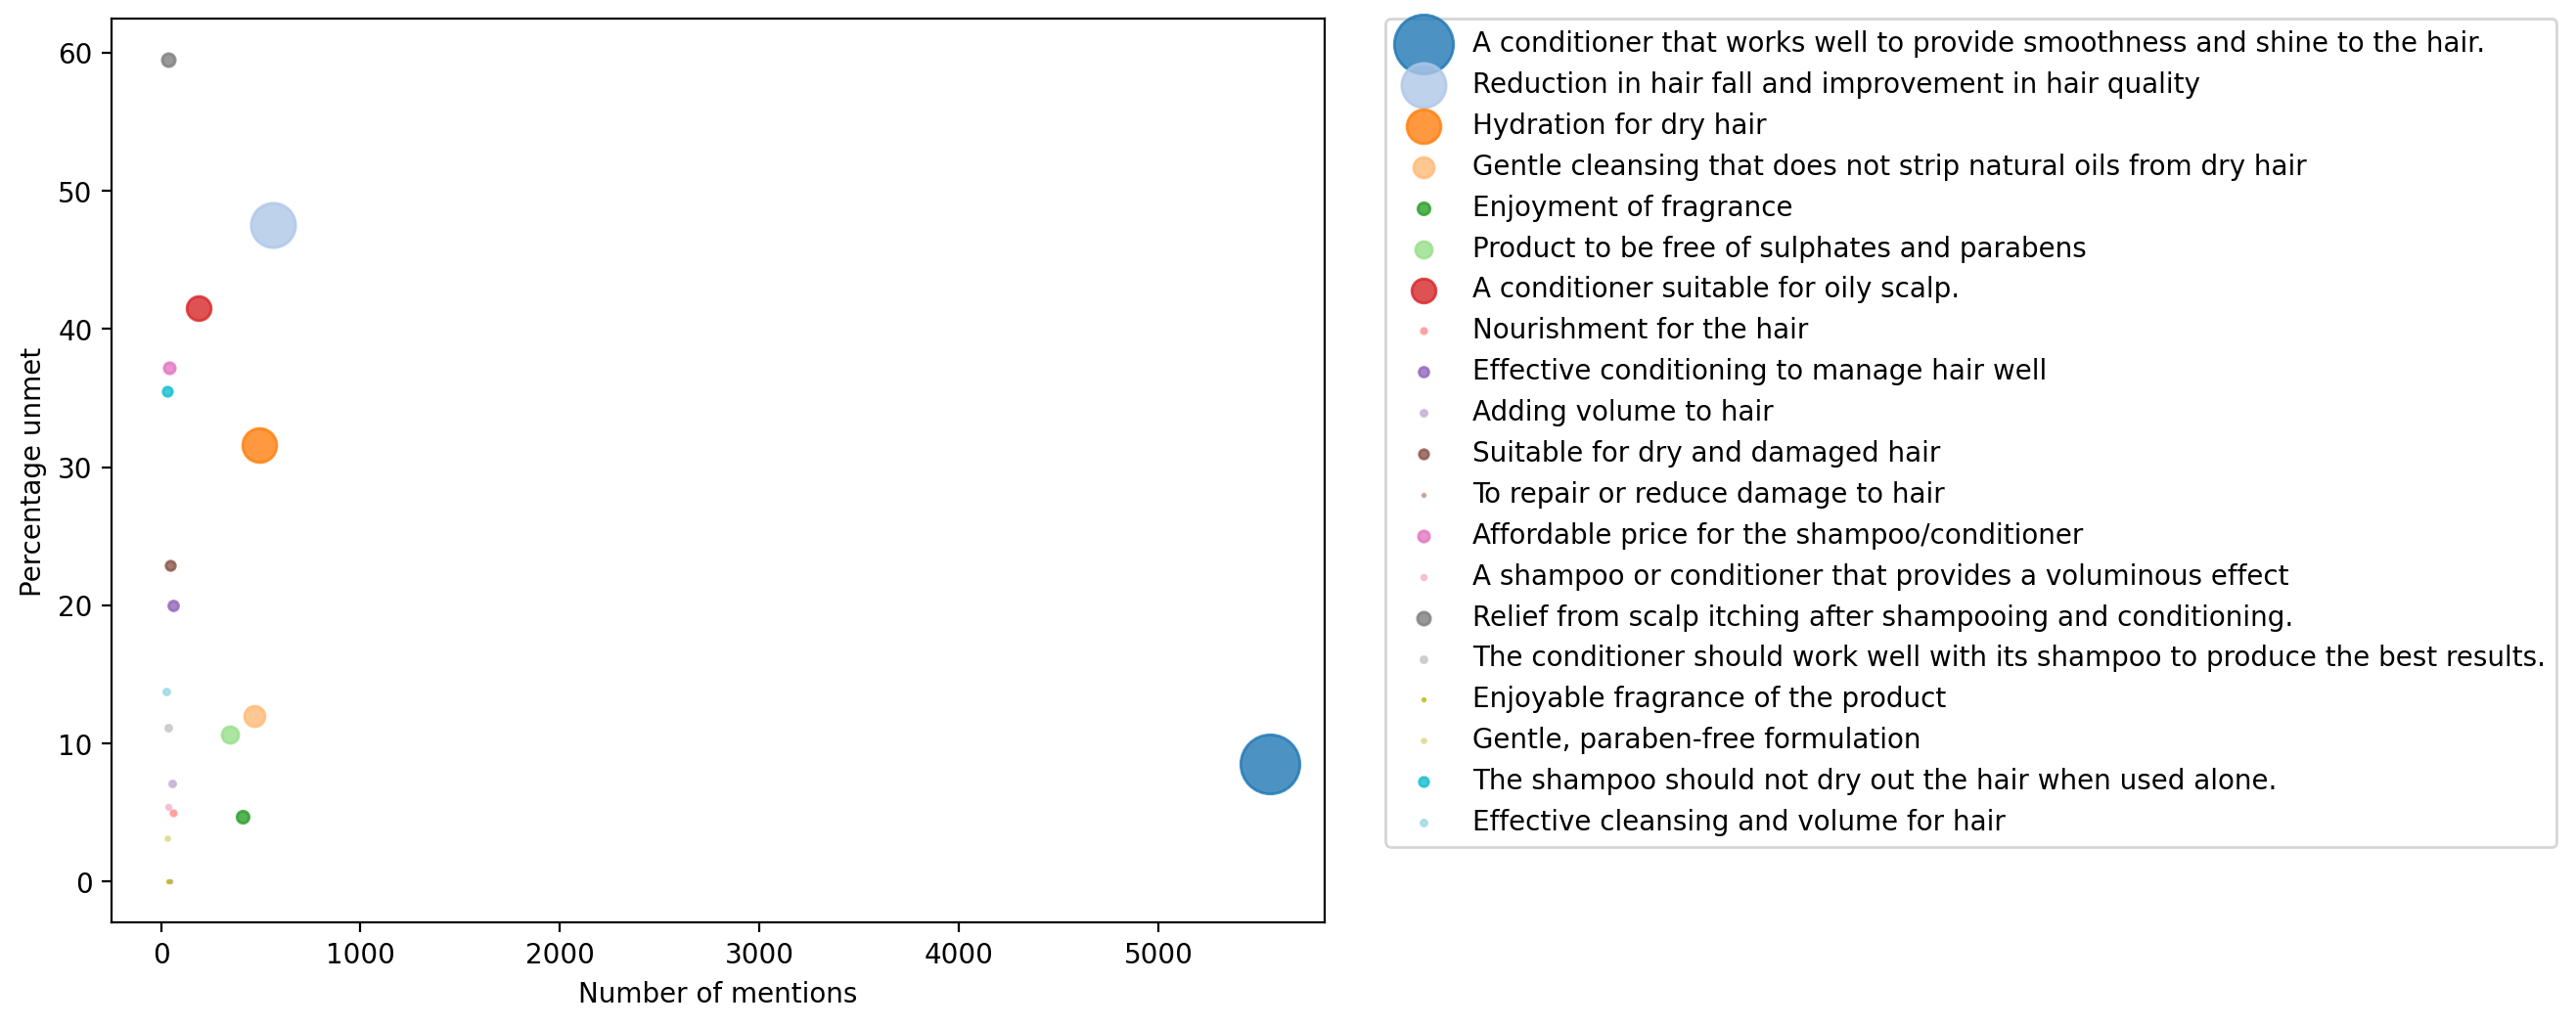

,Total Mentions,Percentage Unmet
Relief from scalp itching after shampooing and conditioning.,37,59.459459
Reduction in hair fall and improvement in hair quality,560,47.500000
A conditioner suitable for oily scalp.,188,41.489362
Affordable price for the shampoo/conditioner,43,37.209302
The shampoo should not dry out the hair when used alone.,31,35.483871
Hydration for dry hair,494,31.578947
Suitable for dry and damaged hair,48,22.916667
Effective conditioning to manage hair well,60,20.000000
Effective cleansing and volume for hair,29,13.793103
Gentle cleansing that does not strip natural oils from dry hair,467,11.991435


In [82]:
df = bubble_plot(
    need_clusters=sample_clusters[:20],
    colors=mpl.color_sequences['tab20'],
    fname="sample2.png",
)
df.sort_values("Percentage Unmet", ascending=False)

/var/folders/_v/gwj34jjx21lcg89_06hppbbm0000gn/T/ipykernel_14756/1027736741.py:34: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(


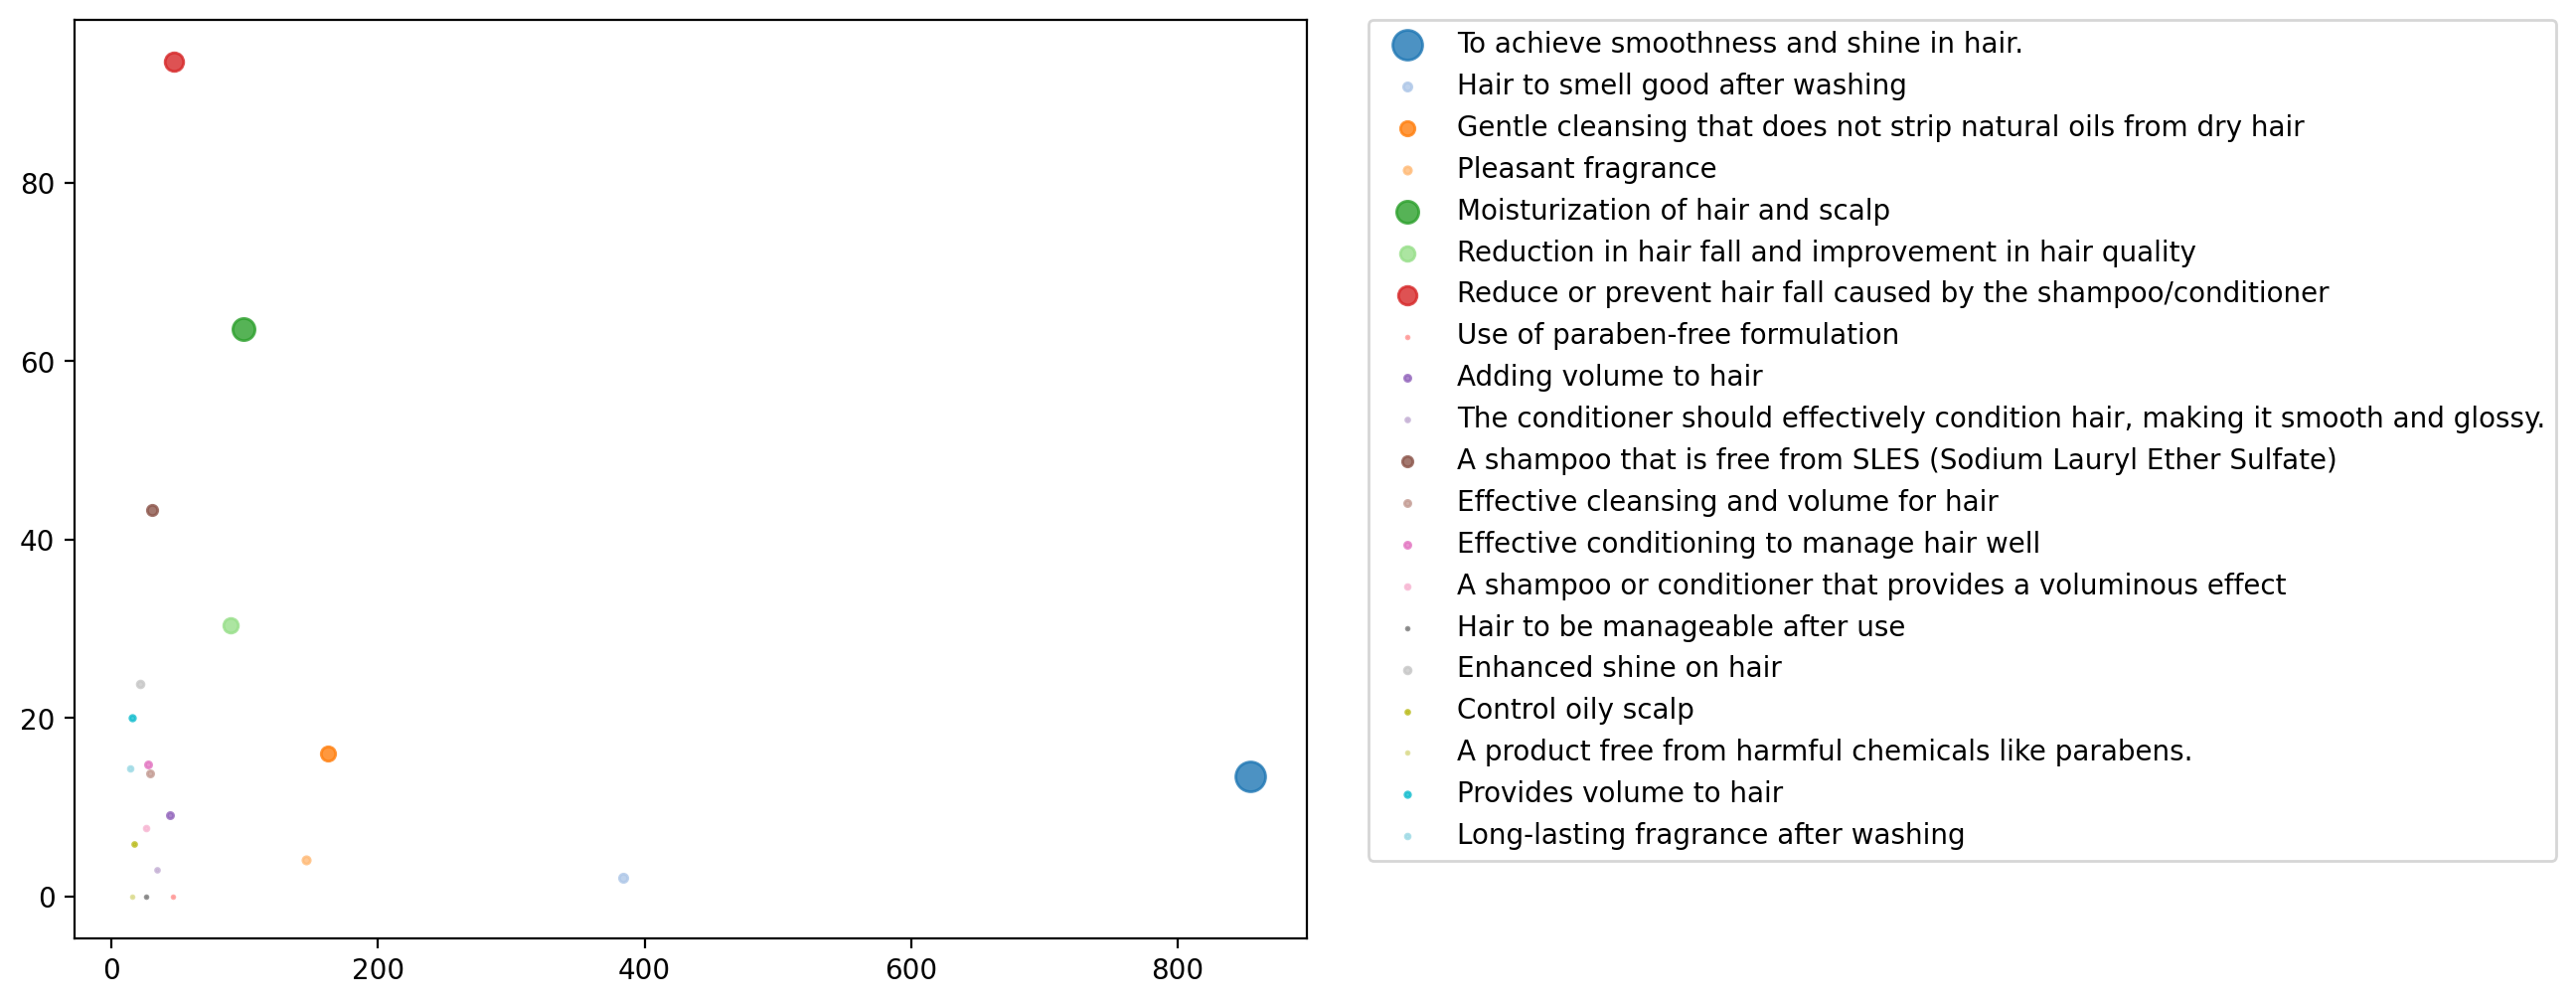

,Total Mentions,Percentage Unmet
Reduce or prevent hair fall caused by the shampoo/conditioner,47,93.617021
Moisturization of hair and scalp,99,63.636364
A shampoo that is free from SLES (Sodium Lauryl Ether Sulfate),30,43.333333
Reduction in hair fall and improvement in hair quality,89,30.337079
Enhanced shine on hair,21,23.809524
Provides volume to hair,15,20.000000
Gentle cleansing that does not strip natural oils from dry hair,162,16.049383
Effective conditioning to manage hair well,27,14.814815
Long-lasting fragrance after washing,14,14.285714
Effective cleansing and volume for hair,29,13.793103


In [201]:
bubble_plot(
    need_clusters=clusters[:20],
    colors=mpl.color_sequences['tab20'],
).sort_values("Percentage Unmet", ascending=False)

In [84]:
sample_size = len(rel)
sample = [
    need
    for i in range(0, sample_size)
    for need in cached_extract_needs(rel, i)
]

sample_embeddings = cached_embed([s.need_description for s in sample])

eps = 0.5
clusters = cluster_dbscan(
    eps=eps,
    items=sample,
    vectors=sample_embeddings,
)

# sort by size, desc
clusters = list(reversed(sorted(clusters, key=lambda x: len(x))))


/var/folders/_v/gwj34jjx21lcg89_06hppbbm0000gn/T/ipykernel_17319/1855779022.py:35: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.



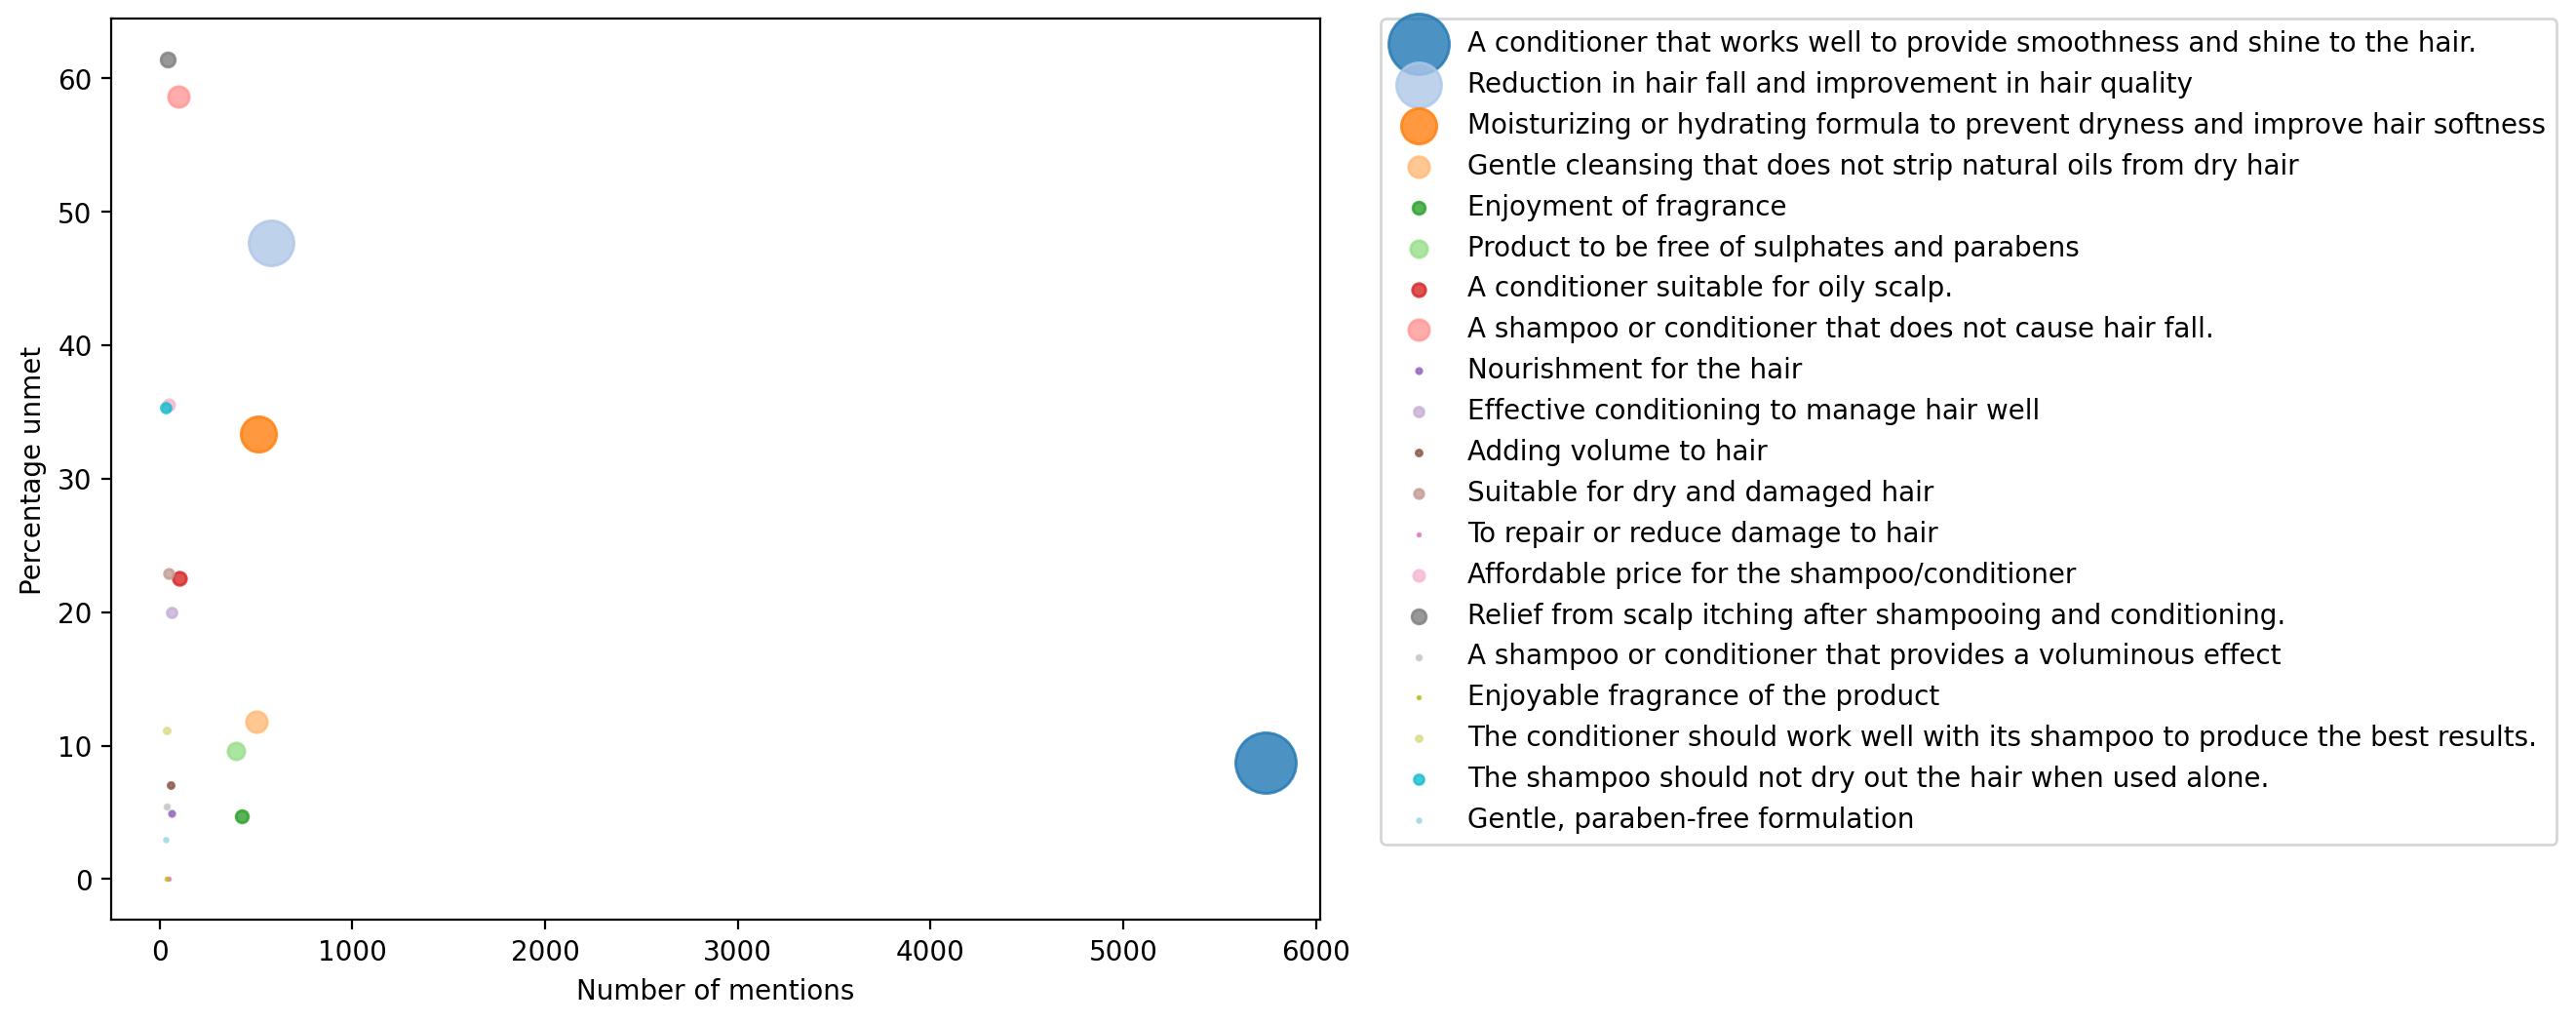

,Total Mentions,Percentage Unmet
Relief from scalp itching after shampooing and conditioning.,44,61.363636
A shampoo or conditioner that does not cause hair fall.,99,58.585859
Reduction in hair fall and improvement in hair quality,577,47.660312
Affordable price for the shampoo/conditioner,45,35.555556
The shampoo should not dry out the hair when used alone.,34,35.294118
Moisturizing or hydrating formula to prevent dryness and improve hair softness,513,33.333333
Suitable for dry and damaged hair,48,22.916667
A conditioner suitable for oily scalp.,102,22.549020
Effective conditioning to manage hair well,60,20.000000
Gentle cleansing that does not strip natural oils from dry hair,501,11.776447


In [85]:
bubble_plot(
    need_clusters=clusters[:20],
    colors=mpl.color_sequences['tab20'],
    fname="full2.png",
).sort_values("Percentage Unmet", ascending=False)

And one more without "A conditioner that works well to provide smoothness and shine to the hair."

/var/folders/_v/gwj34jjx21lcg89_06hppbbm0000gn/T/ipykernel_14756/1855779022.py:35: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(


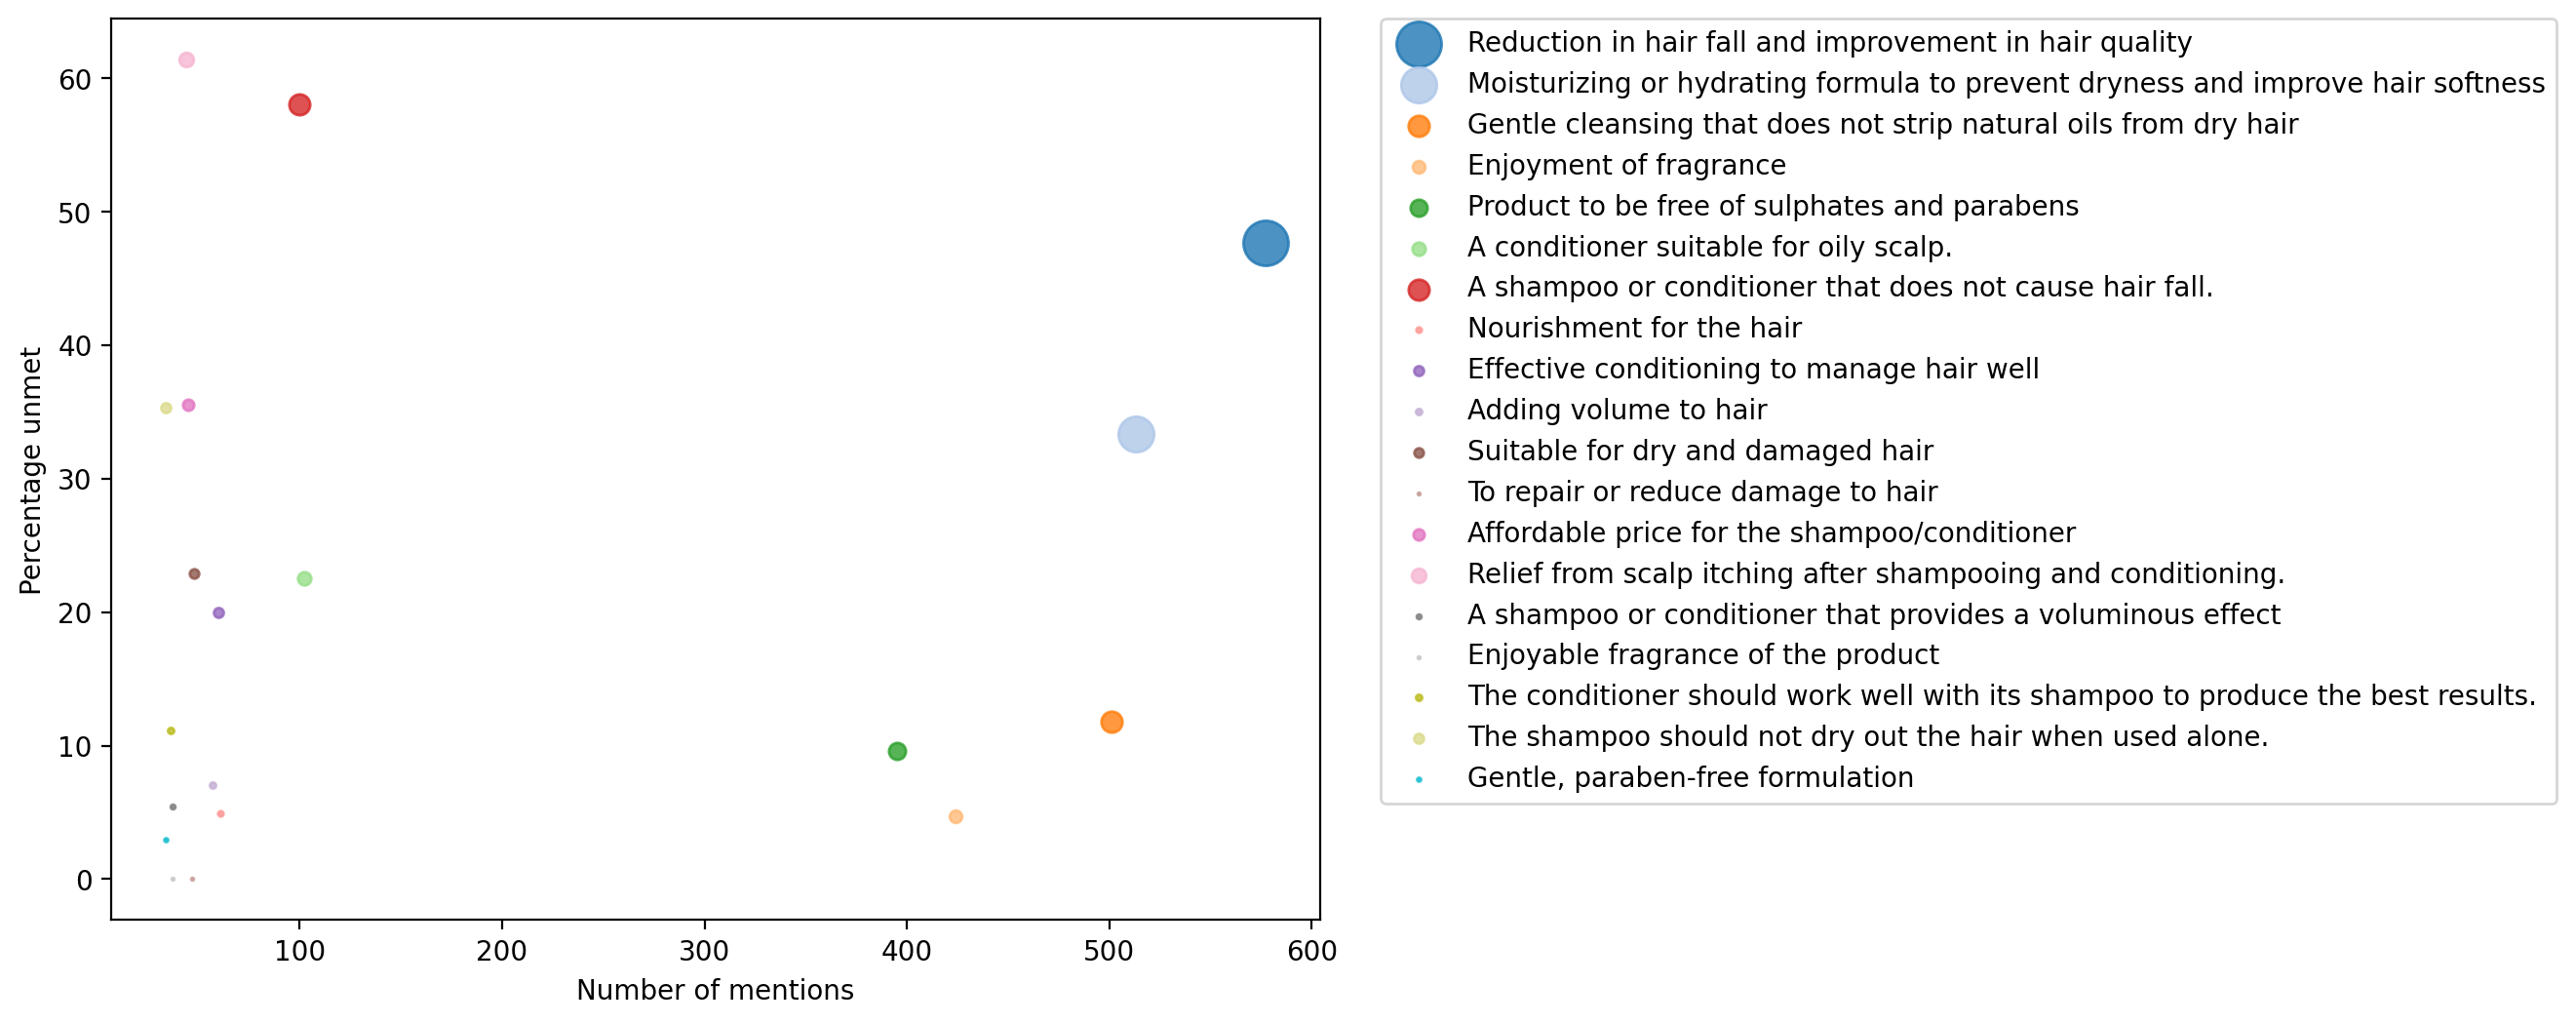

In [319]:
df = bubble_plot(
    fname="without-conditioner.png",
    need_clusters=clusters[1:20], # first one is the super populous one
    colors=mpl.color_sequences['tab20'],
)

Let's pick the top 10 of these, then do a heat map where each layer is a product - what are the products that are meeting the most / fewest needs?

 - things that aren't meeting a lot of needs probably have a weak value proposition or the marketing needs to be reconsidered
 - another thing you're looking for is when there is only one specific product dominating a given need - could be ripe for a competitve product that it just cheaper
 - one more - needs that just aren't really being met: a product that leans into these wouuld theoretically have traction

In [326]:
def heatmap(
        *,
        groups: list[str],
        dimensions: list[str],
        counts_by_dimension: np.ndarray, # (dim X groups)
        title: str,
):
    fig, ax = plt.subplots(figsize=(20, 20))
    im = ax.imshow(
        counts_by_dimension,
        cmap="hot",
    )

    ax.set_xticks(
        range(len(groups)), labels=groups,
        rotation=45, ha="right", rotation_mode="anchor",
    )
    ax.set_yticks(
        range(len(dimensions)),
        labels=dimensions,
    )

    plt.colorbar(
        im,
        fraction=0.03,
        pad=0.04,
    )
    fig.tight_layout()
    fname = ".".join([
        title.replace(" ", "_"),
        "png",
    ])
    plt.savefig(fname, bbox_inches="tight")
    plt.show()
    return

In [88]:
rel_clustered = rel.copy()
rel_clustered["cluster"] = [-1] * len(rel_clustered)
rel_clustered["fulfilled"] = [False] * len(rel_clustered)
for cluster_id, cluster in enumerate(clusters):
    for need in cluster:
        rel_clustered.loc[
            rel_clustered["review_id"] == need.review_id,
            "cluster"
        ] = cluster_id
        rel_clustered.loc[
            rel_clustered["review_id"] == need.review_id,
            "fulfilled"
        ] = need.was_fulfilled
        pass
    pass
#rel_clustered["cluster"].value_counts()

In [61]:
rel_clustered.iloc[0]

product_id                                                        5360840
brand_name                                                Herbal Essences
review_id                                                        10101575
review_title                                            Best conditioner.
review_text                            Makes hair so soft and manageable.
author                                                      Nimisha Yadav
review_date                                           2019-08-15 12:44:09
review_rating                                                         5.0
is_a_buyer                                                          False
pro_user                                                            False
review_label                                                          NaN
product_title           Herbal Essences Strawberry & Mint Conditioner ...
mrp                                                                   380
price                                 

In [62]:
cluster_names = [
    cluster[0].need_description
    for cluster in clusters
]

In [314]:
def cluster_counts_heatmap(
        *,
        title: str,
        df: pd.DataFrame,
):
    counts_by_cluster = df.groupby(["cluster", "product_title"]).size()
    clusters_present = counts_by_cluster.index.get_level_values(0).unique().sort_values()
    products_present = counts_by_cluster.index.get_level_values(1).unique().sort_values()
    counts_df = (
        counts_by_cluster
        .unstack(fill_value=0)
        .reindex(index=clusters_present, columns=products_present, fill_value=0)
    )
    counts_arr = counts_df.to_numpy()
    heatmap(
        groups=products_present,
        dimensions=[cluster_names[i] for i in clusters_present],
        counts_by_dimension=counts_arr,
        title=title,
    )
    return

In [387]:
def cluster_heatmap(
        *,
        title: str,
        df: pd.DataFrame,
):
    df = df.copy()
    product_counts = df["product_title"].value_counts()
    df = df.merge(
        product_counts.reset_index().rename(columns={"count": "product_count"}),
        on="product_title",
    )
    # normalize by the number of reviews per product
    df["weight"] = 1 / df["product_count"]
    counts_by_cluster = df.groupby(["cluster", "product_title"]).agg({"weight": "sum"})
    clusters_present = counts_by_cluster.index.get_level_values(0).unique().sort_values()
    products_present = counts_by_cluster.index.get_level_values(1).unique().sort_values()
    counts_arr = (
        counts_by_cluster
        .unstack(fill_value=0)
        .to_numpy()
    )
    heatmap(
        groups=products_present,
        dimensions=[cluster_names[i] for i in clusters_present],
        counts_by_dimension=counts_arr,
        title=title,
    )
    return


In [334]:
rel["product_title"].value_counts().describe()

count     26.000000
mean     238.346154
std      265.210097
min        2.000000
25%       17.250000
50%      168.000000
75%      338.000000
max      800.000000
Name: count, dtype: float64

We need to normalize by the number of mentions per product in our sample

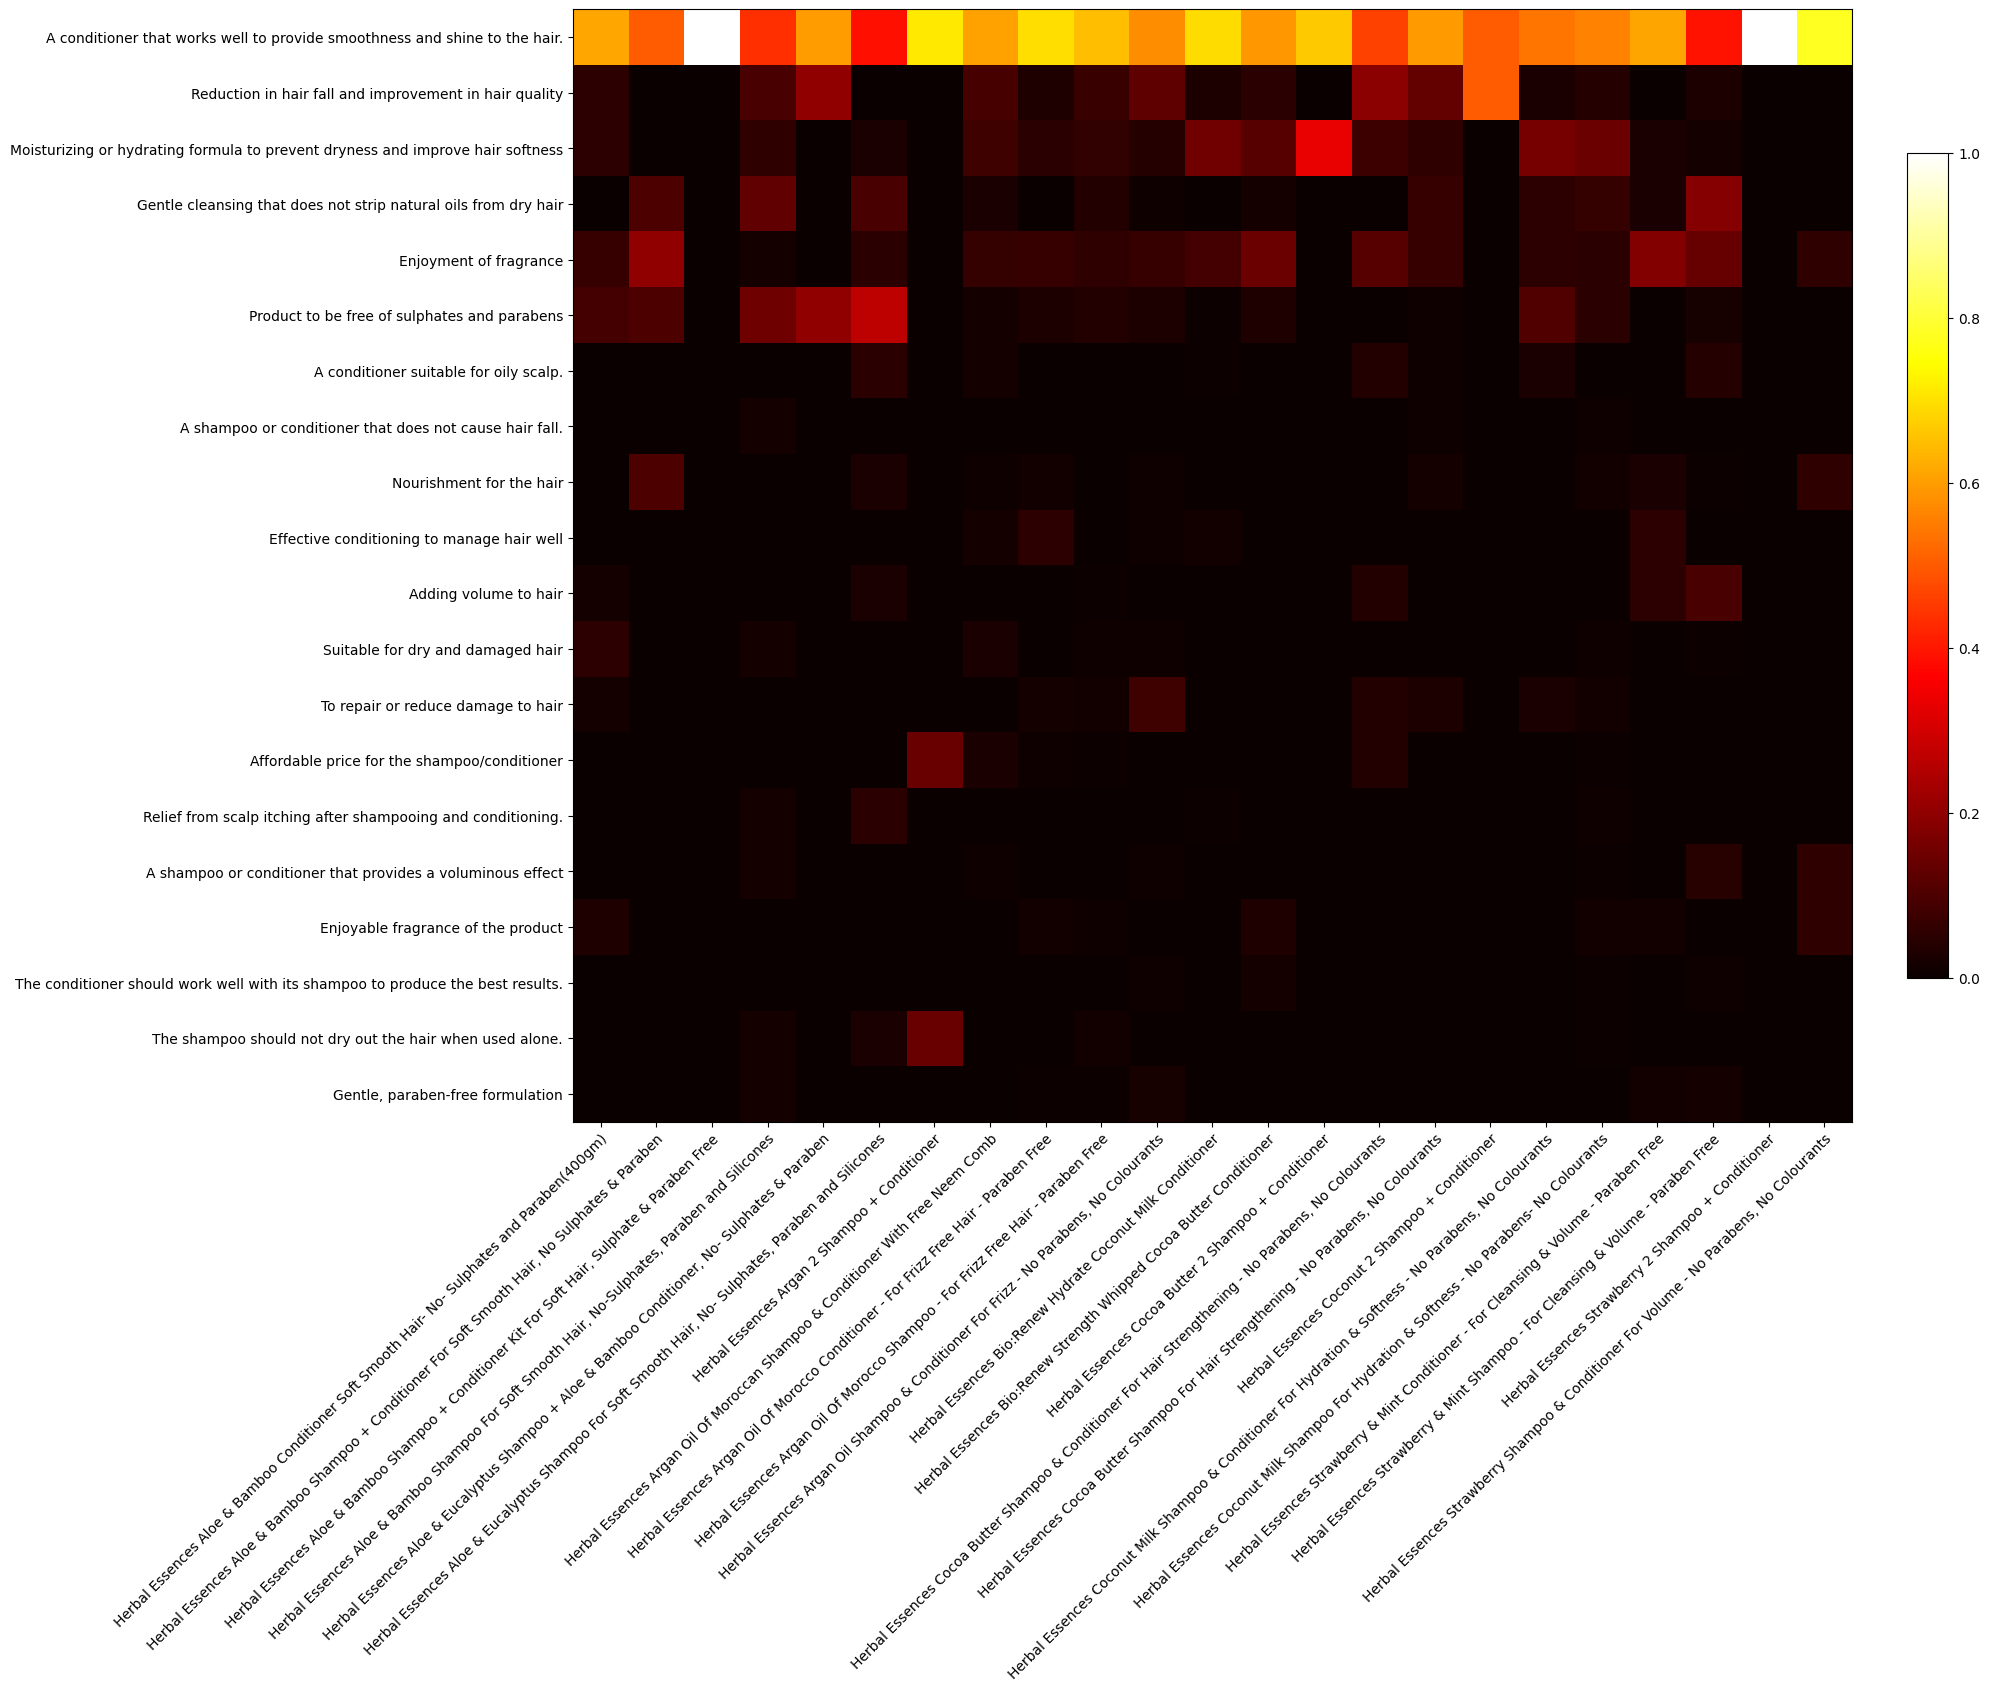

In [388]:
cluster_heatmap(
    title="Conditioner Smoothness",
    df=rel_clustered[
        rel_clustered["fulfilled"]
        & (rel_clustered["cluster"] < 20)
    ]
)

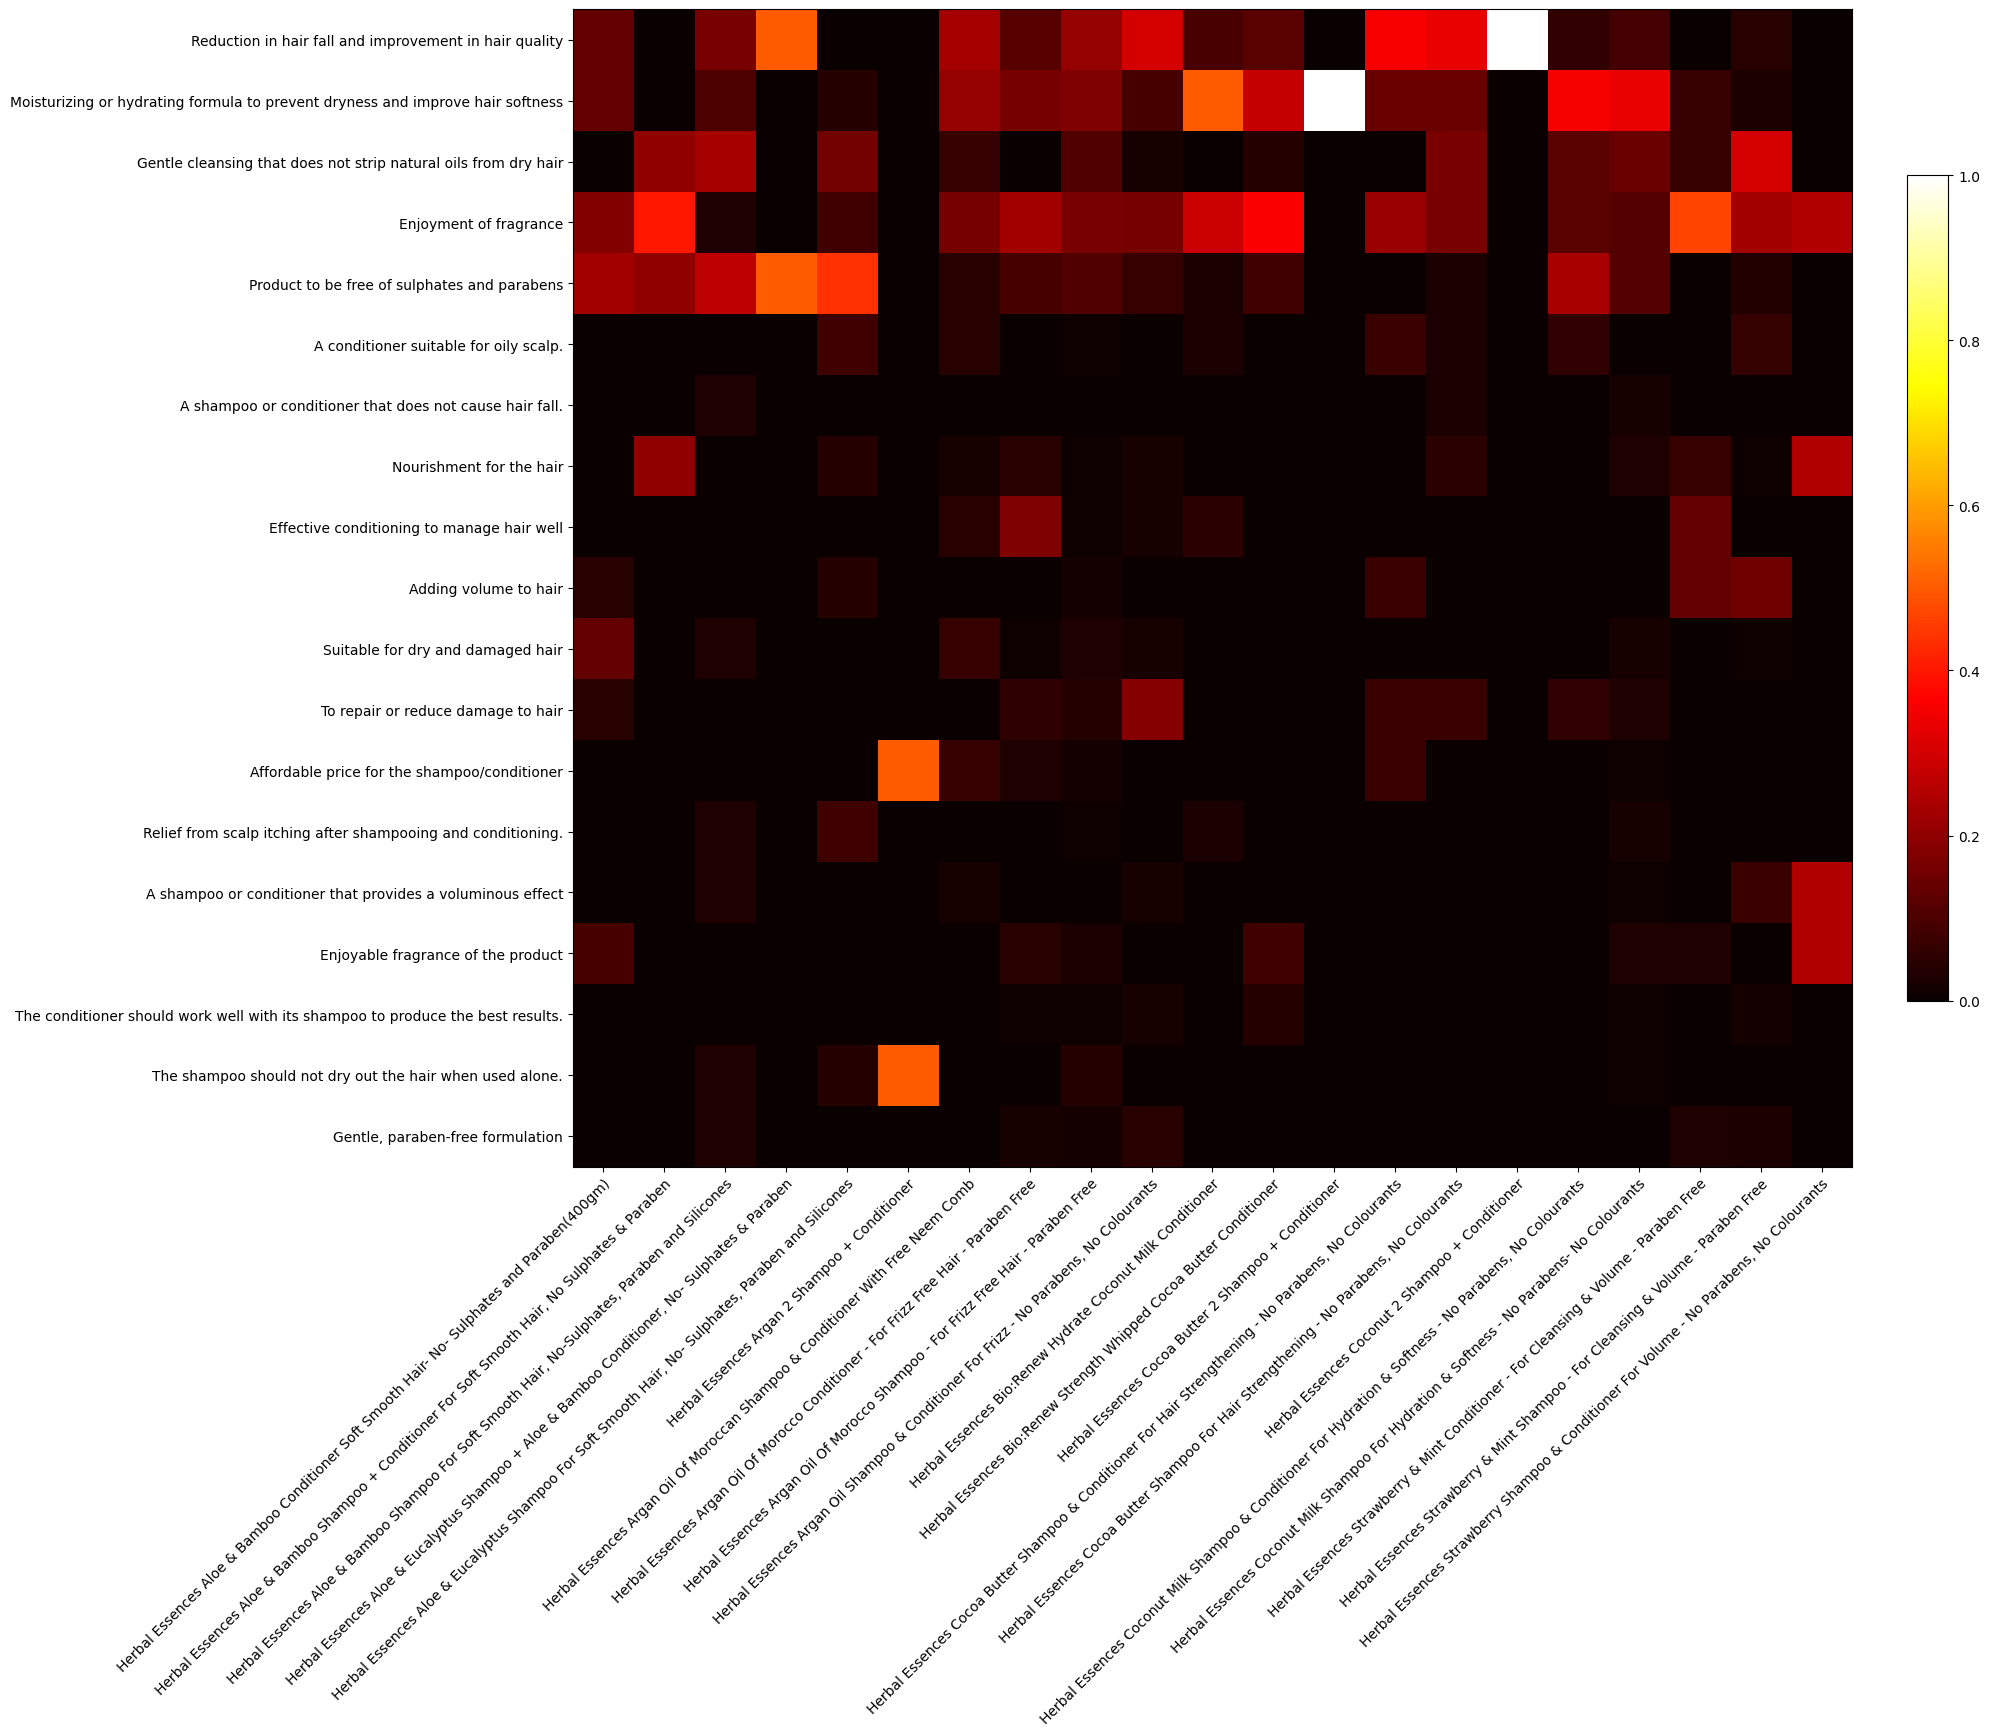

In [389]:
cluster_heatmap(
    title="Needs met by products",
    df=rel_clustered[
        rel_clustered["fulfilled"]
        & (rel_clustered["cluster"] < 20)
        & (rel_clustered["cluster"] != 0)
    ]
)

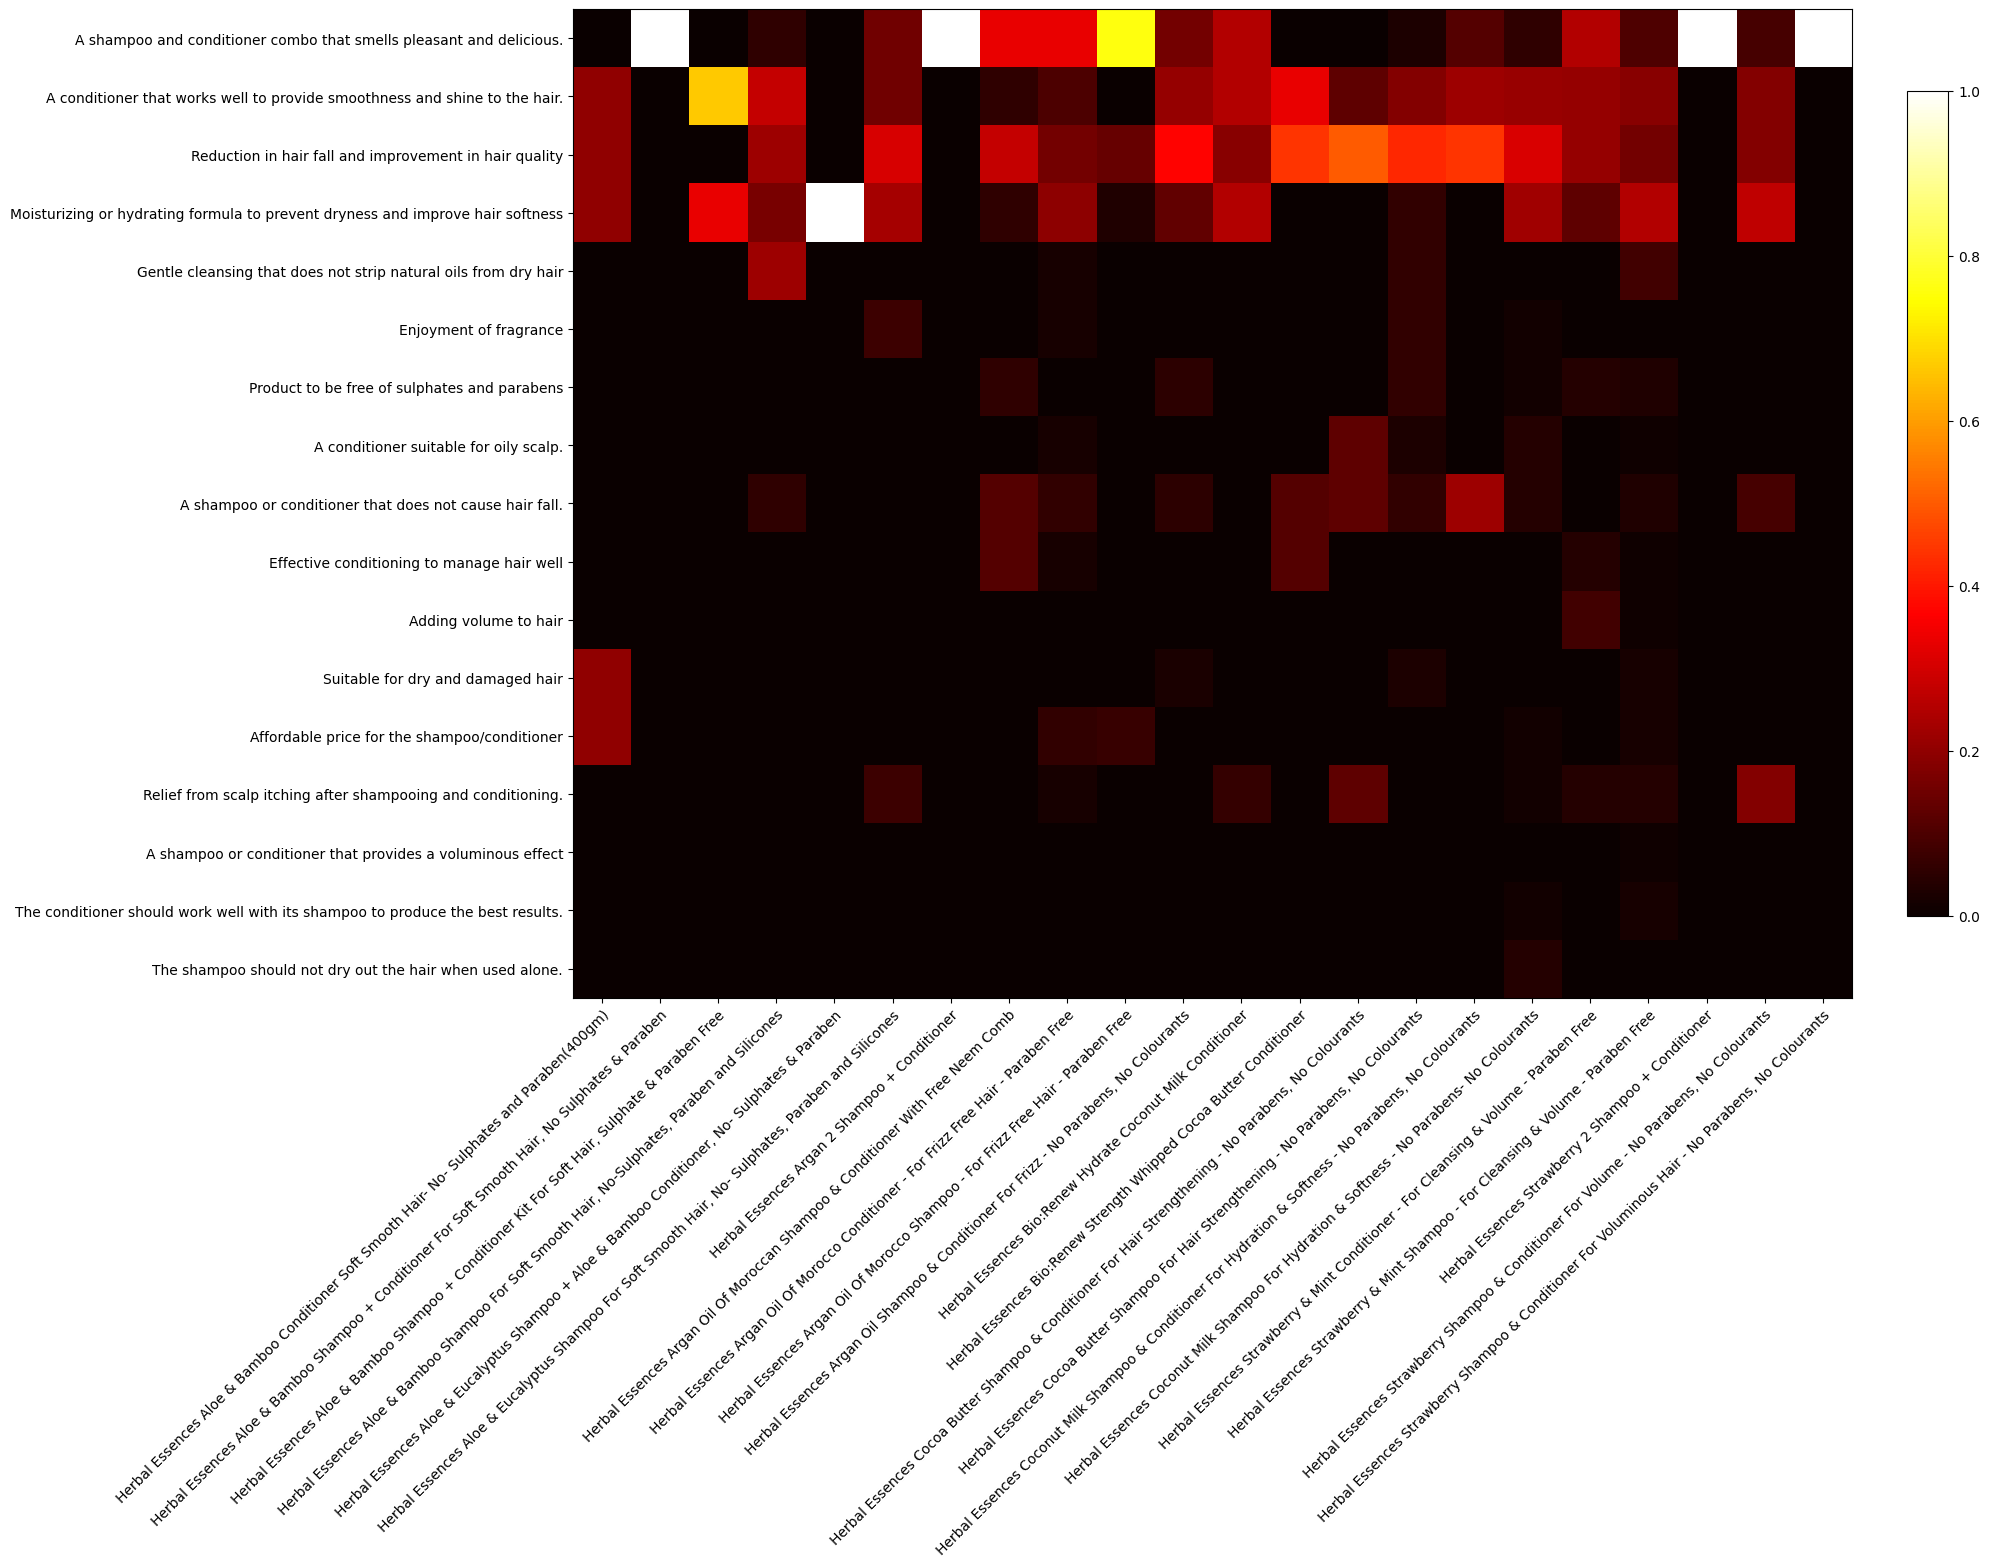

In [390]:
cluster_heatmap(
    title="Needs unmet by products",
    df=rel_clustered[
        ~rel_clustered["fulfilled"]
        & (rel_clustered["cluster"] < 20)
    ]
)

In [246]:
# https://www.statista.com/outlook/cmo/beauty-personal-care/personal-care/hair-care/north-america
# https://www.statista.com/forecasts/1340174/herbal-essences-hair-care-brand-profile-in-the-united-states
market_size_billions = 16
herbal_essences_share = 0.22
herbal_essences_estimated_revenue_billions = market_size_billions * herbal_essences_share
herbal_essences_estimated_revenue_billions

3.52

In [399]:
list(enumerate(cluster_names[:20]))

[(0,
  'A conditioner that works well to provide smoothness and shine to the hair.'),
 (1, 'Reduction in hair fall and improvement in hair quality'),
 (2,
  'Moisturizing or hydrating formula to prevent dryness and improve hair softness'),
 (3, 'Gentle cleansing that does not strip natural oils from dry hair'),
 (4, 'Enjoyment of fragrance'),
 (5, 'Product to be free of sulphates and parabens'),
 (6, 'A conditioner suitable for oily scalp.'),
 (7, 'A shampoo or conditioner that does not cause hair fall.'),
 (8, 'Nourishment for the hair'),
 (9, 'Effective conditioning to manage hair well'),
 (10, 'Adding volume to hair'),
 (11, 'Suitable for dry and damaged hair'),
 (12, 'To repair or reduce damage to hair'),
 (13, 'Affordable price for the shampoo/conditioner'),
 (14, 'Relief from scalp itching after shampooing and conditioning.'),
 (15, 'A shampoo or conditioner that provides a voluminous effect'),
 (16, 'Enjoyable fragrance of the product'),
 (17,
  'The conditioner should work well

In [402]:
# proportion of unmet needs regarding 'reduction in hair fall'
100.0 * len(rel_clustered[
    ((rel_clustered["cluster"] == 1)
     | (rel_clustered["cluster"] == 7))
    & ~rel_clustered["fulfilled"]
]) / len(rel)

2.162336614490883

In [422]:
# proportion of unmet needs regarding 'not stripping oils'
100.0 * len(rel_clustered[
    (rel_clustered["cluster"] == 3)
    & ~rel_clustered["fulfilled"]
]) / len(rel)

0.24205260609972568

In [440]:
# proportion of unmet needs regarding 'Relief from scalp itching'
100.0 * len(rel_clustered[
    (rel_clustered["cluster"] == 14)
    & ~rel_clustered["fulfilled"]
]) / len(rel)

0.19364208487978055

In [244]:
(2.16 + 0.24 + 0.19)

2.5900000000000003

In [441]:
# estimated revenue being lost on those above pain points:
lost_revenue_millions = (((2.16 + 0.24 + 0.19) / 100.0) * herbal_essences_estimated_revenue_billions) * 1000.0
lost_revenue_millions

91.168

In [288]:
# https://gcimagazine.texterity.com/gcimagazine/may_2024/MobilePagedArticle.action?articleId=1972798#articleId1972798
retention_estimate = 0.2
repeat_revenue_billions = retention_estimate * herbal_essences_estimated_revenue_billions
repeat_revenue_billions

0.7040000000000001

In [293]:
estimated_retention_improvement = 0.01
#nominal_improvement_billions = repeat_revenue_billions * (1 + estimated_retention_improvement) - repeat_revenue_billions
nominal_improvement_billions = ((retention_estimate + estimated_retention_improvement) * herbal_essences_estimated_revenue_billions) - repeat_revenue_billions
nominal_improvement_billions

0.03520000000000001

In [294]:
nominal_improvement_billions * 1000.0

35.20000000000001

# Simplified need visualization

In [56]:
def need_bubble(df, *, title: str):
    need_ids = list(df["cluster"].unique())
    data = pd.DataFrame({
        "need_id": need_ids,
        "Need": [cluster_names[i] for i in need_ids],
        "count": [
            len(df[df["cluster"] == need_id])
            for need_id in need_ids
        ],
        "Percent Unmet": [
            (
                100.0 * len(df[(df["cluster"] == need_id)
                       & ~df["fulfilled"]])
                / len(df[(df["cluster"] == need_id)])
            )
            for need_id in need_ids
        ],
        "y": [0] * len(need_ids),
        "size": [1] * len(need_ids),
    })
    fig = px.scatter(
        data,
        x="Percent Unmet",
        y="y",
        size="count",
        color="Need",
        #hover_name="need",
        #text="need_ids",
        #log_x=True,
        #size_max=60,
        width=1200,
        height=800,
    )
    fig.update_yaxes(ticklabelposition=None, title=None)
    fig.update_layout(
        # scene = dict(
        #     # xaxis = dict(visible=False),
        #     yaxis = dict(visible=False),
        #     # zaxis =dict(visible=False)
        # ),
        yaxis_range=[-0.1, 0.1],
    )
    #fig.write_image(f"{title}.jpeg")
    fig.show()
    return

In [89]:
rel_clustered["cluster"].value_counts().sort_values(ascending=False)

cluster
0      1186
1       221
2       211
4       151
3       102
       ... 
866       1
867       1
868       1
610       1
618       1
Name: count, Length: 3270, dtype: int64

# Simplified

In [105]:
[
    (i, clusters[i][0].need_description)
    for i in df["cluster"].unique()
]

[(2,
  'Moisturizing or hydrating formula to prevent dryness and improve hair softness'),
 (9, 'Effective conditioning to manage hair well'),
 (4, 'Enjoyment of fragrance'),
 (5, 'Product to be free of sulphates and parabens'),
 (1, 'Reduction in hair fall and improvement in hair quality'),
 (14, 'Relief from scalp itching after shampooing and conditioning.'),
 (3, 'Gentle cleansing that does not strip natural oils from dry hair'),
 (8, 'Nourishment for the hair'),
 (6, 'A conditioner suitable for oily scalp.')]

/var/folders/_v/gwj34jjx21lcg89_06hppbbm0000gn/T/ipykernel_17319/2938004110.py:36: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.



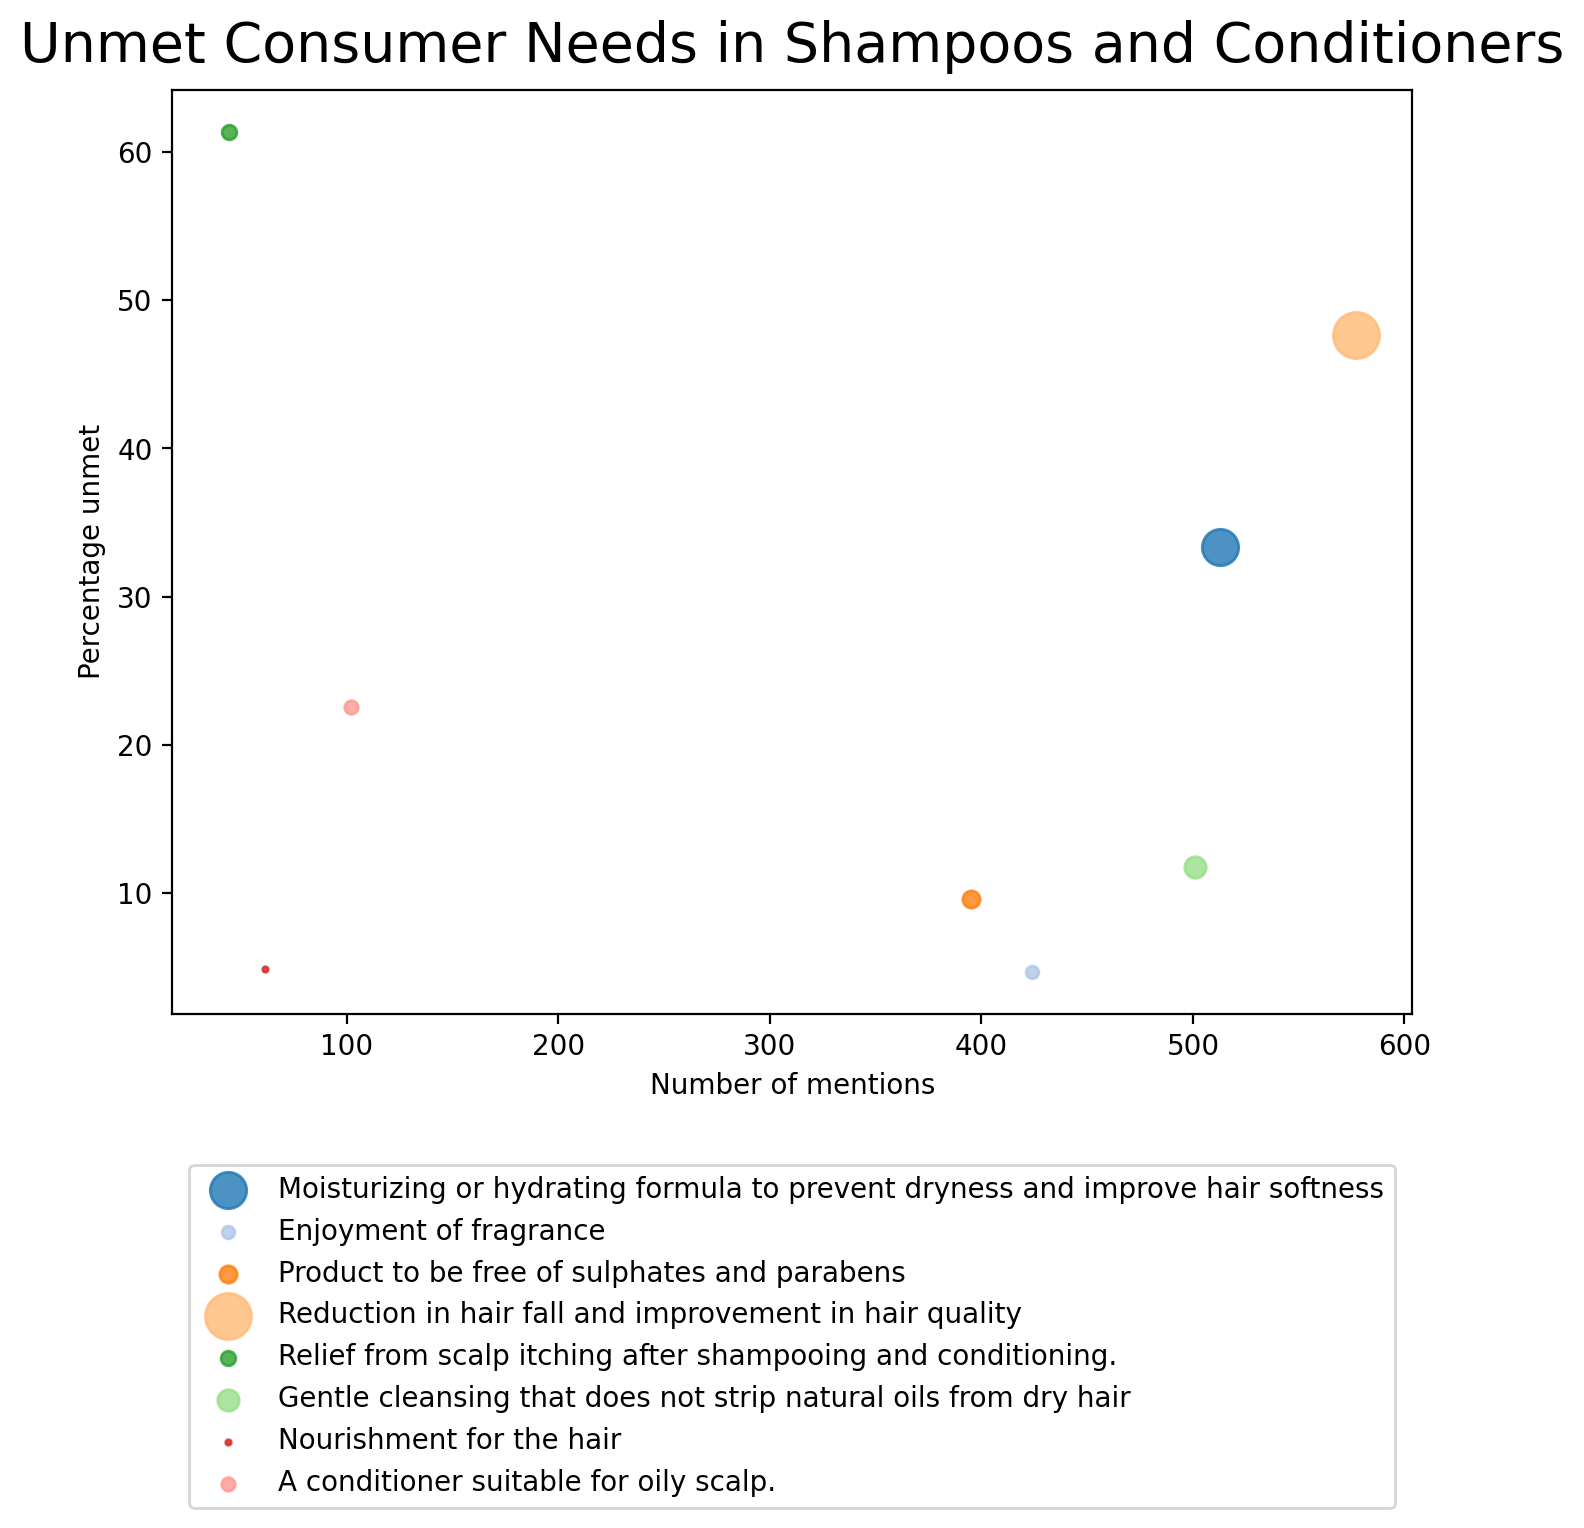

In [309]:
# less bubbles
df = rel_clustered.copy()
df.loc[df["cluster"] == 7, "cluster"] = 1
df = df[
    df["cluster"].apply(lambda cluster_id: (
        (
            cluster_id > 0
            and cluster_id < 9
        )
        or cluster_id in [14]
    ))
].copy()
bubble_plot(
    fname="simplified-needs.png",
    need_clusters=[clusters[i] for i in df["cluster"].unique()],
    colors=mpl.color_sequences['tab20'],
    title="Unmet Consumer Needs in Shampoos and Conditioners",
)
None

Now a spider graph showing the overlap of the undifferentiated products

In [310]:
# create the 'need profile' of each product
df = rel_clustered.copy()
df.loc[df["cluster"] == 7, "cluster"] = 1
df.loc[df["cluster"] == 8, "cluster"] = 5
df = df[
    df["cluster"].apply(lambda cluster_id: (
        (
            cluster_id > 0
            and cluster_id < 9
        )
        or cluster_id in [14]
    ))
].copy()
product_counts = df["product_title"].value_counts()
df = df.merge(
    product_counts.reset_index().rename(columns={"count": "product_count"}),
    on="product_title",
)
df["weight"] = 1 / df["product_count"]
counts_by_product = df.groupby(["product_title", "cluster"]).agg({"weight": "sum"})
counts_by_product = counts_by_product.unstack(fill_value=0)

In [311]:
[(i, clusters[i][0].need_description) for i in df["cluster"].sort_values().unique()]

[(1, 'Reduction in hair fall and improvement in hair quality'),
 (2,
  'Moisturizing or hydrating formula to prevent dryness and improve hair softness'),
 (3, 'Gentle cleansing that does not strip natural oils from dry hair'),
 (4, 'Enjoyment of fragrance'),
 (5, 'Product to be free of sulphates and parabens'),
 (6, 'A conditioner suitable for oily scalp.'),
 (14, 'Relief from scalp itching after shampooing and conditioning.')]

In [312]:
counts_by_product.loc["Herbal Essences Aloe & Bamboo Conditioner Soft Smooth Hair- No- Sulphates and Paraben(400gm)"]

        cluster
weight  1          0.235294
        2          0.235294
        3          0.000000
        4          0.235294
        5          0.294118
        6          0.000000
        14         0.000000
Name: Herbal Essences Aloe & Bamboo Conditioner Soft Smooth Hair- No- Sulphates and Paraben(400gm), dtype: float64

In [313]:
poorly_differentiated = [
    "Herbal Essences Strawberry & Mint Shampoo - For Cleansing & Volume - Paraben Free",
    "Herbal Essences Aloe & Bamboo Shampoo For Soft Smooth Hair, No-Sulphates, Paraben and Silicones",
    "Herbal Essences Bio:Renew Strength Whipped Cocoa Butter Conditioner",
    "Herbal Essences Coconut Milk Shampoo For Hydration & Softness - No Parabens- No Colourants",
]

In [314]:
all_products = list(
    set(counts_by_product.index).difference(set(poorly_differentiated))

)

In [315]:
categories = [clusters[i][0].need_description for i in df["cluster"].sort_values().unique()]

In [316]:
categories

['Reduction in hair fall and improvement in hair quality',
 'Moisturizing or hydrating formula to prevent dryness and improve hair softness',
 'Gentle cleansing that does not strip natural oils from dry hair',
 'Enjoyment of fragrance',
 'Product to be free of sulphates and parabens',
 'A conditioner suitable for oily scalp.',
 'Relief from scalp itching after shampooing and conditioning.']

In [318]:
# clean up the names a little
categories = [
    "Reduces hair fall",
    "Prevents dryness",
    "Does not strip natural oils",
    "Enjoyment of fragrance",
    "Free of sulphates and parabens",
    "Suitable for oily scalp",
    "Relief from scalp itching",
]

In [319]:
import plotly.graph_objects as go

def spider_chart_needs(
        *,
        products: list[str],
        title: str,
):
     fig = go.Figure(
         layout=go.Layout(
             autosize=False,
             width=1400,
             height=700,
         ),
     )
     fig.update_layout(title=title)

     for pname in products:
         fig.add_trace(go.Scatterpolar(
               r=list(counts_by_product.loc[pname]),
               theta=categories,
               fill='toself',
               name=pname,
         ))
         pass

     fig.update_layout(
       polar=dict(
         radialaxis=dict(
           visible=False,
           range=[0, 0.6]
         )),
       showlegend=False
     )
     fig.write_image(f"{title.replace(' ', '_')}.jpeg")
     fig.show()
     return

In [320]:
spider_chart_needs(
    title="Other Products",
    products=all_products,
)

2025-06-30T07:15:08-0700.661 INFO chromium - __init__: Chromium init'ed with kwargs {}


2025-06-30T07:15:08-0700.677 INFO chromium - __init__: Found chromium path: /Applications/Google Chrome.app/Contents/MacOS/Google Chrome


2025-06-30T07:15:08-0700.678 INFO _tmpfile - __init__: Temp directory created: /var/folders/_v/gwj34jjx21lcg89_06hppbbm0000gn/T/tmpqck_ztbi.


2025-06-30T07:15:08-0700.679 INFO browser_async - open: Opening browser.


2025-06-30T07:15:08-0700.681 INFO _tmpfile - __init__: Temp directory created: /var/folders/_v/gwj34jjx21lcg89_06hppbbm0000gn/T/tmp2fi_f1mu.


2025-06-30T07:15:08-0700.681 INFO chromium - pre_open: Temporary directory at: /var/folders/_v/gwj34jjx21lcg89_06hppbbm0000gn/T/tmp2fi_f1mu


2025-06-30T07:15:13-0700.380 INFO kaleido - _conform_tabs: Conforming 1 to file:///var/folders/_v/gwj34jjx21lcg89_06hppbbm0000gn/T/tmpqck_ztbi/index.html


2025-06-30T07:15:13-0700.384 INFO kaleido - _conform_tabs: Waiting on all navigates


2025-06-30T07:15:14-0700.155 INFO kaleido - _conform_tabs: All navigates done, putting them all in queue.


2025-06-30T07:15:14-0700.156 INFO kaleido - _get_kaleido_tab: Getting tab from queue (has 1)


2025-06-30T07:15:14-0700.157 INFO kaleido - _get_kaleido_tab: Got 6515


2025-06-30T07:15:14-0700.157 INFO _kaleido_tab - _calc_fig: Processing Other_Products-2.jpeg


2025-06-30T07:15:14-0700.157 INFO _kaleido_tab - _calc_fig: Sending big command for Other_Products-2.jpeg.


2025-06-30T07:15:14-0700.208 INFO _kaleido_tab - _calc_fig: Sent big command for Other_Products-2.jpeg.


2025-06-30T07:15:14-0700.209 INFO kaleido - _return_kaleido_tab: Reloading tab 6515 before return.


2025-06-30T07:15:14-0700.274 INFO kaleido - _return_kaleido_tab: Putting tab 6515 back (queue size: 0).


2025-06-30T07:15:14-0700.274 INFO kaleido - __aexit__: Waiting for all cleanups to finish.


2025-06-30T07:15:14-0700.275 INFO kaleido - __aexit__: Exiting Kaleido


2025-06-30T07:15:14-0700.276 INFO _tmpfile - clean: TemporaryDirectory.cleanup() worked.


2025-06-30T07:15:14-0700.277 INFO _tmpfile - clean: shutil.rmtree worked.


2025-06-30T07:15:14-0700.277 INFO kaleido - close: Cancelling tasks.


2025-06-30T07:15:14-0700.277 INFO kaleido - close: Exiting Kaleido/Choreo


2025-06-30T07:15:14-0700.277 INFO browser_async - close: Closing browser.


2025-06-30T07:15:14-0700.283 INFO _tmpfile - clean: TemporaryDirectory.cleanup() worked.


2025-06-30T07:15:14-0700.283 INFO _tmpfile - clean: shutil.rmtree worked.


2025-06-30T07:15:14-0700.284 INFO kaleido - close: Cancelling tasks.


2025-06-30T07:15:14-0700.284 INFO kaleido - close: Exiting Kaleido/Choreo


2025-06-30T07:15:14-0700.285 INFO browser_async - close: Closing browser.


2025-06-30T07:15:14-0700.370 INFO _tmpfile - clean: TemporaryDirectory.cleanup() worked.


2025-06-30T07:15:14-0700.370 INFO _tmpfile - clean: shutil.rmtree worked.


In [321]:
spider_chart_needs(
    title="Poorly-Differentiated Products",
    products=poorly_differentiated,
)

2025-06-30T07:15:14-0700.385 INFO chromium - __init__: Chromium init'ed with kwargs {}


2025-06-30T07:15:14-0700.387 INFO chromium - __init__: Found chromium path: /Applications/Google Chrome.app/Contents/MacOS/Google Chrome


2025-06-30T07:15:14-0700.388 INFO _tmpfile - __init__: Temp directory created: /var/folders/_v/gwj34jjx21lcg89_06hppbbm0000gn/T/tmpqksi4dlv.


2025-06-30T07:15:14-0700.389 INFO browser_async - open: Opening browser.


2025-06-30T07:15:14-0700.390 INFO _tmpfile - __init__: Temp directory created: /var/folders/_v/gwj34jjx21lcg89_06hppbbm0000gn/T/tmpznd07wtq.


2025-06-30T07:15:14-0700.390 INFO chromium - pre_open: Temporary directory at: /var/folders/_v/gwj34jjx21lcg89_06hppbbm0000gn/T/tmpznd07wtq


2025-06-30T07:15:14-0700.706 INFO kaleido - _conform_tabs: Conforming 1 to file:///var/folders/_v/gwj34jjx21lcg89_06hppbbm0000gn/T/tmpqksi4dlv/index.html


2025-06-30T07:15:14-0700.714 INFO kaleido - _conform_tabs: Waiting on all navigates


2025-06-30T07:15:15-0700.438 INFO kaleido - _conform_tabs: All navigates done, putting them all in queue.


2025-06-30T07:15:15-0700.439 INFO kaleido - _get_kaleido_tab: Getting tab from queue (has 1)


2025-06-30T07:15:15-0700.439 INFO kaleido - _get_kaleido_tab: Got A0DB


2025-06-30T07:15:15-0700.439 INFO _kaleido_tab - _calc_fig: Processing Poorly_Differentiated_Products.jpeg


2025-06-30T07:15:15-0700.439 INFO _kaleido_tab - _calc_fig: Sending big command for Poorly_Differentiated_Products.jpeg.


2025-06-30T07:15:15-0700.474 INFO _kaleido_tab - _calc_fig: Sent big command for Poorly_Differentiated_Products.jpeg.


2025-06-30T07:15:15-0700.475 INFO kaleido - _return_kaleido_tab: Reloading tab A0DB before return.


2025-06-30T07:15:15-0700.733 INFO kaleido - _return_kaleido_tab: Putting tab A0DB back (queue size: 0).


2025-06-30T07:15:15-0700.734 INFO kaleido - __aexit__: Waiting for all cleanups to finish.


2025-06-30T07:15:15-0700.734 INFO kaleido - __aexit__: Exiting Kaleido


2025-06-30T07:15:15-0700.735 INFO _tmpfile - clean: TemporaryDirectory.cleanup() worked.


2025-06-30T07:15:15-0700.735 INFO _tmpfile - clean: shutil.rmtree worked.


2025-06-30T07:15:15-0700.735 INFO kaleido - close: Cancelling tasks.


2025-06-30T07:15:15-0700.736 INFO kaleido - close: Exiting Kaleido/Choreo


2025-06-30T07:15:15-0700.736 INFO browser_async - close: Closing browser.


2025-06-30T07:15:15-0700.741 INFO _tmpfile - clean: TemporaryDirectory.cleanup() worked.


2025-06-30T07:15:15-0700.741 INFO _tmpfile - clean: shutil.rmtree worked.


2025-06-30T07:15:15-0700.742 INFO kaleido - close: Cancelling tasks.


2025-06-30T07:15:15-0700.743 INFO kaleido - close: Exiting Kaleido/Choreo


2025-06-30T07:15:15-0700.743 INFO browser_async - close: Closing browser.


2025-06-30T07:15:15-0700.827 INFO _tmpfile - clean: TemporaryDirectory.cleanup() worked.


2025-06-30T07:15:15-0700.827 INFO _tmpfile - clean: shutil.rmtree worked.


2025-06-30T07:15:15-0700.830 INFO _tmpfile - clean: TemporaryDirectory.cleanup() worked.


2025-06-30T07:15:15-0700.830 INFO _tmpfile - clean: shutil.rmtree worked.
